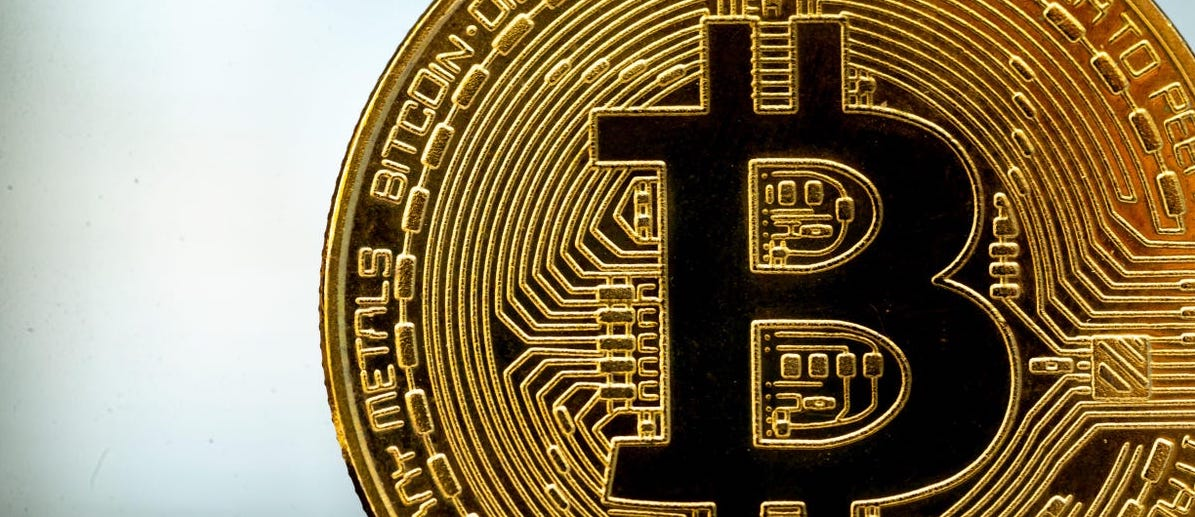
<div align="center">Source: <b> forbes.com </b></div>

# Bitcoin's Realized Volatility Forecasting with GARCH, GARCH-NET family and Multivariate LSTM, GRU, RNN, ANN and CNN

Author: **Gino Ferretti**

## Overview

Volatility is generally accepted as the best measure of market risk and volatility forecasting is used in many different applications across the industry including risk management, value-at-risk, portfolio construction and optimisation, active fund management, risk-parity investing, and derivatives trading. 

Volatility attempts to measure magnitude of price movements that a financial instrument experiences over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa.

The purpose of this project is to take a sneak peek into the future by **forecasting the next 7 days' average daily realized volatility of BTC-USD** using 2 different approaches - the traditional econometric approach to volatility prediction of financial time series **GARCH** and state-of-the-art **LSTM Neural Networks**.

## Business Problem

Since Bitcoin's first appearance in 2009, it has changed the world's financial landscape substantially. The decentralized cryptocurrency has established itself as an asset class recognized by many asset managers, large investment banks and hedge funds. As the speed of mainstream adoption continues to soar, it is also leading investors to explore a new venture, such as crypto options.

Bitcoin has been historically known to be more volatile than regulated stocks and commodities. Its most recent surge in late December 2020, early January 2021 has brought about a lot of questions and uncertainties about the future financial landscape. At the point of writing this report (August 2021), Bitcoin is traded at slightly above USD 50,000, which is no small feat considering its traded price at the beginning of 2020 was only USD 7,200. 

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. On top of that, since crypto option trading is relatively new, there has not been as much research done on this Bitcoin volatility forecasting. Crytocurrencies carry certain nuances that differ themselves from traditional regulated stocks and commodities, which would also need to be accounted for.

## Dataset

The historical dataset of Bitcoin Open/Close/High/Low prices were obtained using the Yahoo Finance API **`yfinance`**. This API is free, very easy to set up, but yet still contains a wide range of data and offerings. 

I will be downloading BTC-USD prices using ticker `BTC-USD` at 1-day interval. Yahoo did not add Bitcoin until 2014; and therefore although it was first traded in 2009, **`yfinance`** only contains data from September 2014 until now (September 2023). I would therefore be working with over 2,500 datapoints covering about 7 years of trading days.

### Installing & Importing Libraries 

(Please uncomment the 2 cells below to install `yfinance` and `arch` libraries if you don't already have them).

In [69]:
# !pip install arch

In [70]:
# !pip3 install yfinance

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [74]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [75]:
directory_to_img = os.path.join('..', '..', 'images')

### History of Bitcoin

First appearance... blablabla

Why Yahoo Finance only has data from 2014.

In [76]:
# SET SEED FOR REPRODUCIBILITY
seed = 42

In [77]:
start = datetime(2014, 1, 1)
end = datetime(2023, 1, 1)

tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)

df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

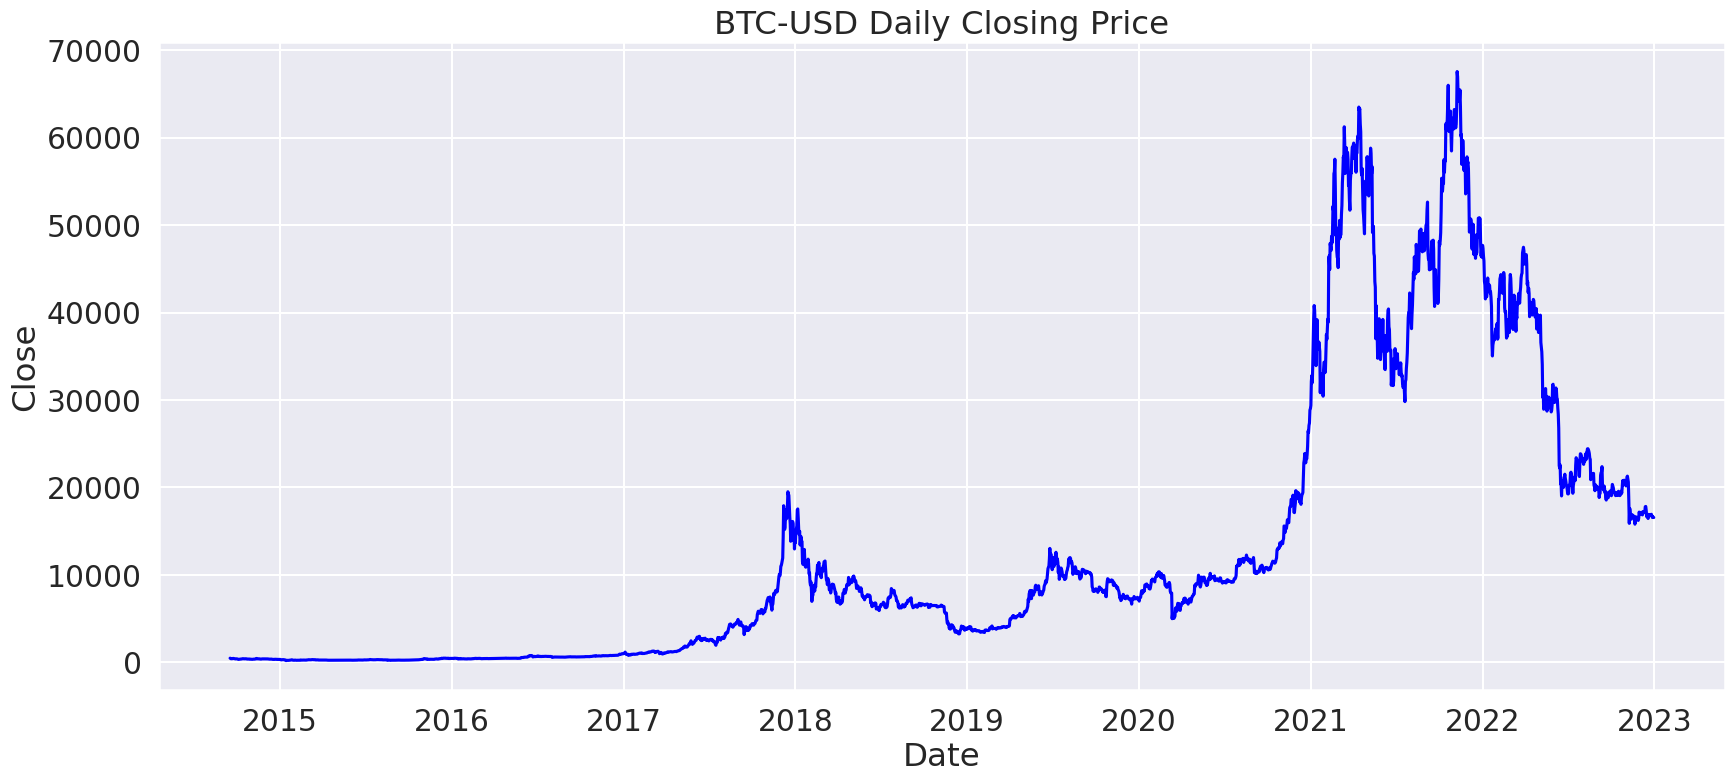

In [78]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    

# plt.tight_layout()
plt.savefig(os.path.join('close.png'), dpi=300, bbox_inches='tight');

### **Types of Volatility and How They are Measured**

(Source: https://www.investopedia.com/terms/v/vix.asp)  

Volatility does not measure the direction of price changes of a financial instrument, merely its dispersions over a certain period of time. The more dramatic the price swings are in that instrument, the higher the level of volatility, and vice versa. High volatility is associated with higher risk, and low volatility low risk.

Volatility can either be historical or implied; both are usually expressed in percentage terms. 

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time. Realized Volatility is commonly calculated as the standard deviation of price returns,
which is the dollar change in price as a percentage of previous day's price.
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price.

(The main focus of this project is **NOT implied volatility**, which traditionally can be derived from option pricing models such as the Black Scholes Model). 

In [79]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in mathematic modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable:


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [80]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))
# df['log_returns'] = df['returns']**2

In [81]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  Dividends  Stock Splits   returns  \
Date                                                                     
2014-09-17 00:00:00+00:00  21056800        0.0           0.0       NaN   
2014-09-18 00:00:00+00:00  34483200        0.0           0.0 -7.192558   
2014-09-19 00:00:00+00:00  37919700        0.0           0.0 -6.984265   
2014-09-20 00:00:00+00:00  36863600        0.0           0.0  3.573492   
2014-09-21 00:00:00+00:00  26580100        0.0           0.0 -2.465854   

                           log_returns  
Date                                    
2014-09-17 00:00:00+00:00          NaN  
2014-09-18 00:00:00+00:00    -0.074643  
2014-09-19 00:00:00+00:00    -0.072402  
2014-09-20 00:00:00+00:00     0.035111  
2014-09-21 00:00:00+00:00    -0.024968

In [82]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

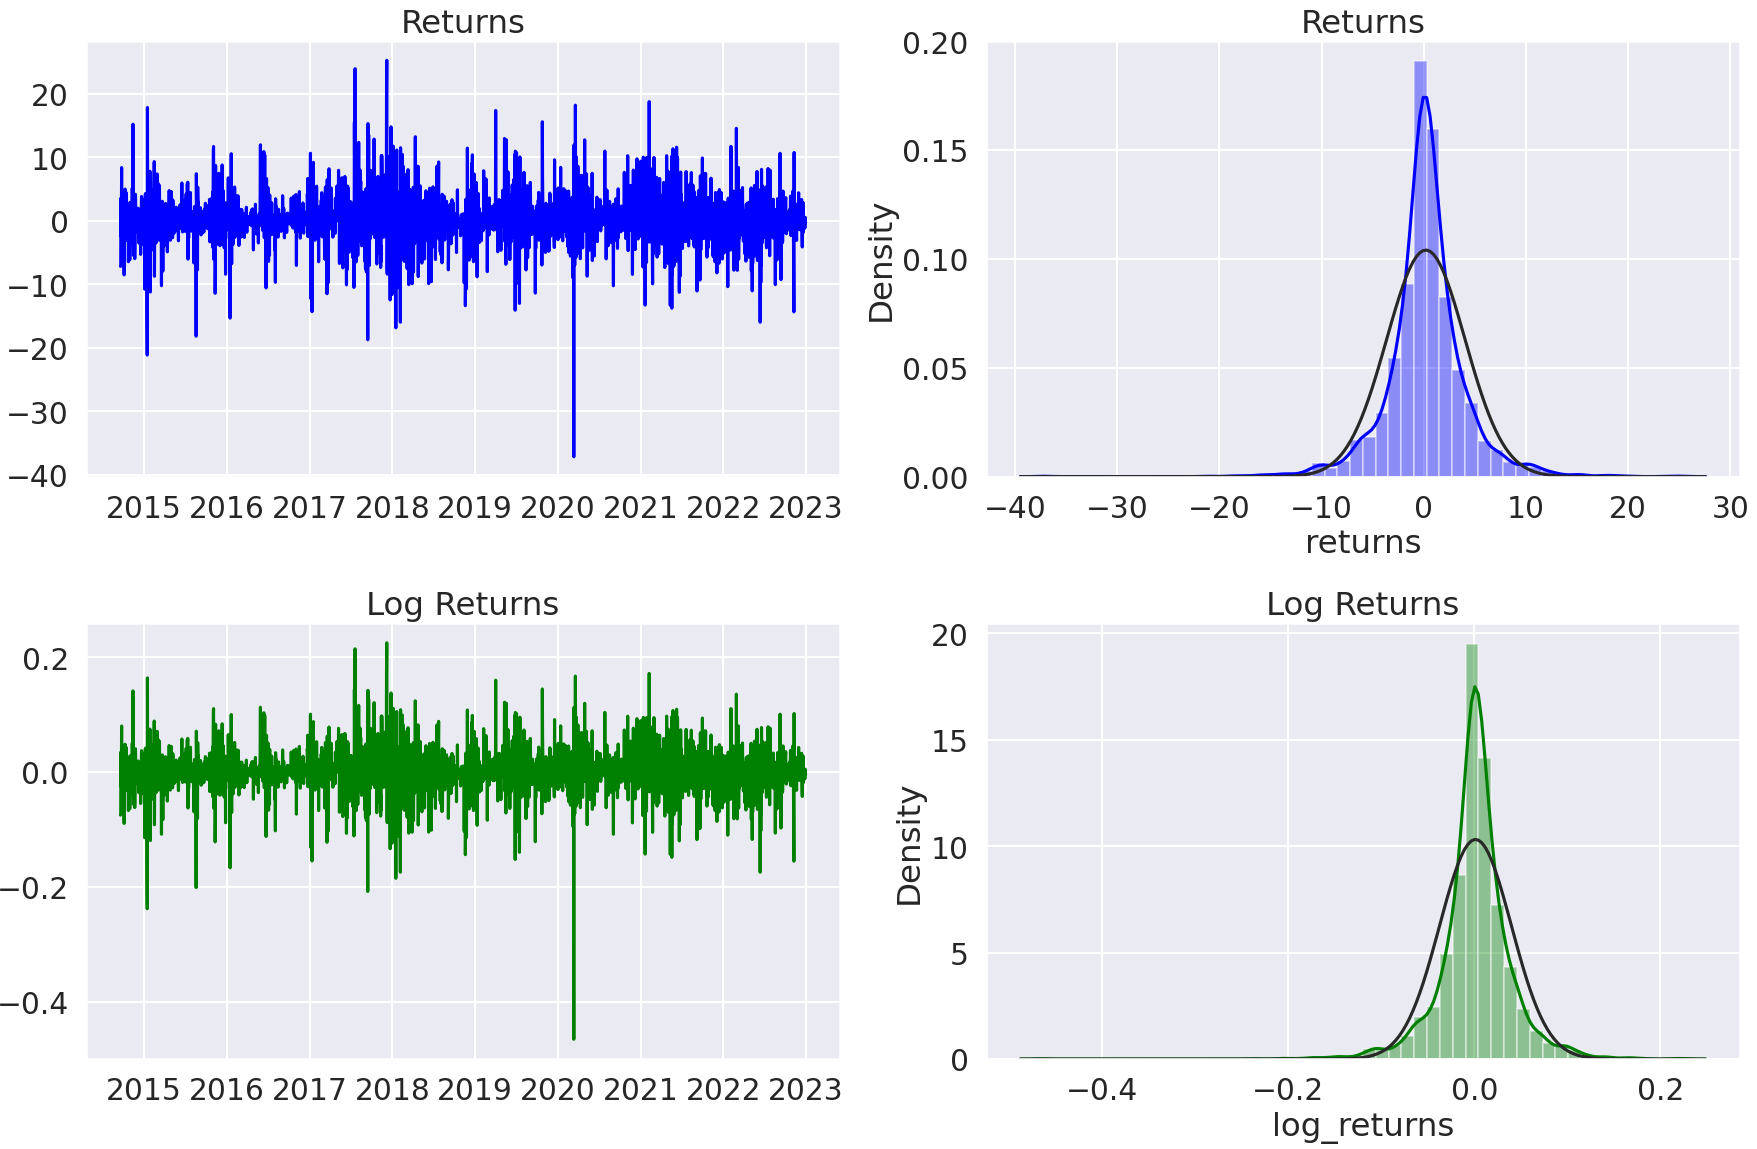

In [83]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    plt.savefig(os.path.join('returns_logreturns.png'), 
                dpi=300, bbox_inches='tight')
    fig.show();

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thicker tails than the standard normal distribution.


In [84]:
df.returns.describe()

count    3027.000000
mean        0.192806
std         3.833356
min       -37.169539
25%        -1.365826
50%         0.171375
75%         1.774518
max        25.247169
Name: returns, dtype: float64

In [85]:
df.log_returns.describe()

count    3027.000000
mean        0.001186
std         0.038664
min        -0.464730
25%        -0.013752
50%         0.001712
75%         0.017590
max         0.225119
Name: log_returns, dtype: float64

(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)

The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed interval window (`INTERVAL_WINDOW`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`INTERVAL_WINDOW - 1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [86]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

For this specific project I'll experiment with an interval window of 30 days (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to forecast the average realized volatility of the next `n_future` 7 days using a number of immediate past/historical datapoints (`n_past`). 


In [87]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

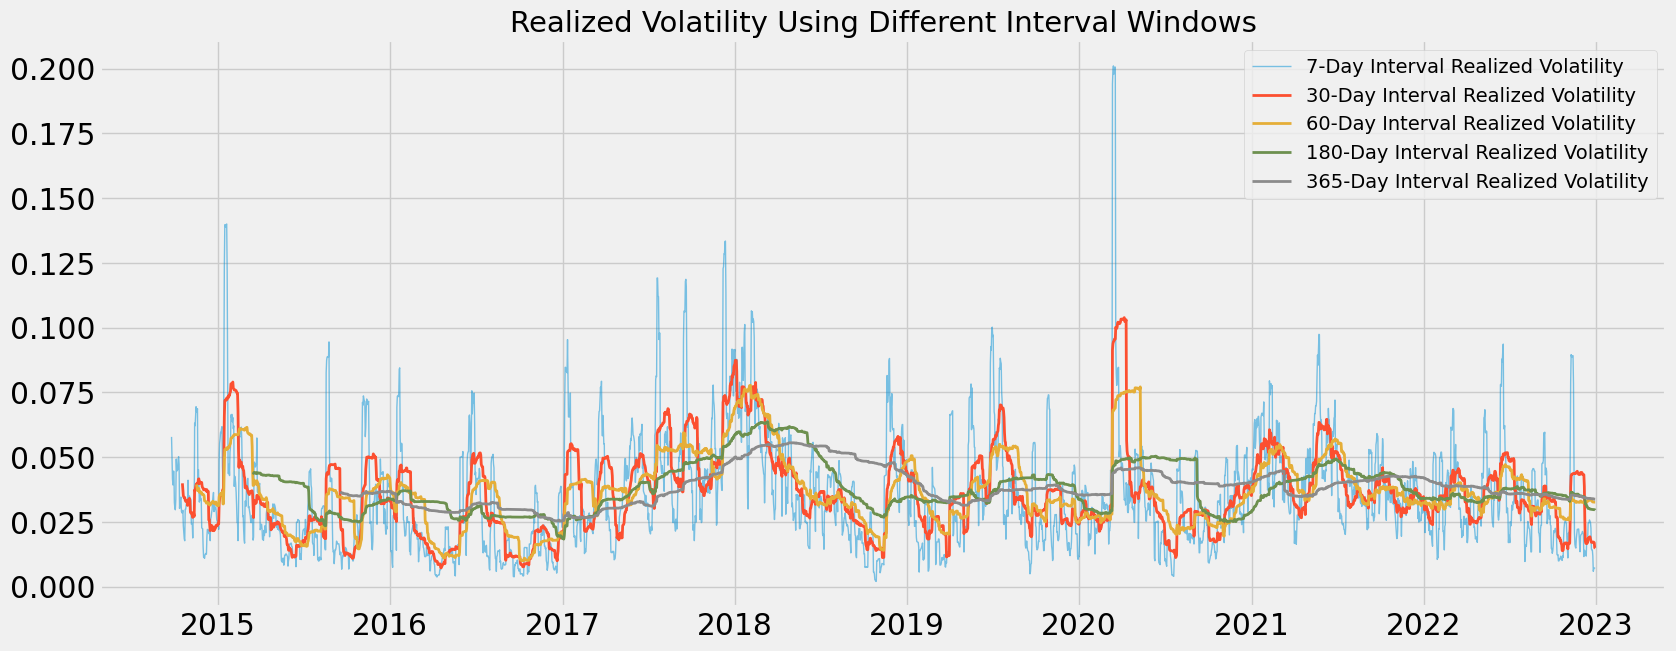

In [88]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.savefig(os.path.join('diff_intervals.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

The reason I selected 30 days is because 7 days seems too noisy to observe meaningful patterns, while longer intervals seem to smooth the volatility down significantly and tend to revert back to the mean.

Using interval window of 30 days would also help avoid wasting too many datapoints at the beginning of the dataset.

Time-series forecasting models are the models that are capable to predict **future** values based on previously observed values. Target "**future**" data in this case is obtained by **shifting the current volatility backward** by the number of `n_future` lags. 

For example, respected to last week's Monday, this week's Monday is the "**future**"; therefore I just need to shift the volatility this week back by 7 days, and use it as the desired "**future**" output for last week, which I would then use for Neural Networks training and model performance evaluation. 

In [89]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [90]:
df.describe()

Open          High           Low         Close        Volume  \
count   3027.000000   3027.000000   3027.000000   3027.000000  3.027000e+03   
mean   12862.464048  13186.768039  12499.397236  12866.276490  1.634923e+10   
std    16191.423939  16605.740177  15711.733948  16186.454049  1.997611e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      674.770020    685.498993    663.923492    676.813507  1.012915e+08   
50%     7102.259766   7293.560547   6898.282227   7116.804199  7.370770e+09   
75%    16809.051758  17090.261719  16534.487305  16808.360352  2.793474e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     3027.0        3027.0  3027.000000  3027.000000  2998.000000   
mean         0.0           0.0     0.192806     0.001186     0.035926   
std          0.0           0.0     3.833356     0.038664     0.016158   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.365826    -0.013752     0.025235   
50%          0.0           0.0     0.171375     0.001712     0.033822   
75%          0.0           0.0     1.774518     0.017590     0.044398   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  2991.000000  
mean      0.035927  
std       0.016177  
min       0.007228  
25%       0.025216  
50%       0.033802  
75%       0.044430  
max       0.103878

The 2 columns `Dividends` and `Stock Splits` don't store any information, all rows are `0.0`. So I'll remove them.

In [91]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [92]:
df.describe()

Open          High           Low         Close        Volume  \
count   3027.000000   3027.000000   3027.000000   3027.000000  3.027000e+03   
mean   12862.464048  13186.768039  12499.397236  12866.276490  1.634923e+10   
std    16191.423939  16605.740177  15711.733948  16186.454049  1.997611e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      674.770020    685.498993    663.923492    676.813507  1.012915e+08   
50%     7102.259766   7293.560547   6898.282227   7116.804199  7.370770e+09   
75%    16809.051758  17090.261719  16534.487305  16808.360352  2.793474e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  3027.000000  3027.000000  2998.000000  2991.000000  
mean      0.192806     0.001186     0.035926     0.035927  
std       3.833356     0.038664     0.016158     0.016177  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.365826    -0.013752     0.025235     0.025216  
50%       0.171375     0.001712     0.033822     0.033802  
75%       1.774518     0.017590     0.044398     0.044430  
max      25.247169     0.225119     0.103878     0.103878

Since I am currently using an `INTERVAL_WINDOW` of 30 and a horizon `n_future` of  7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [93]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

In [94]:
# print(plt.style.available)

## **Exploratory Data Analysis**

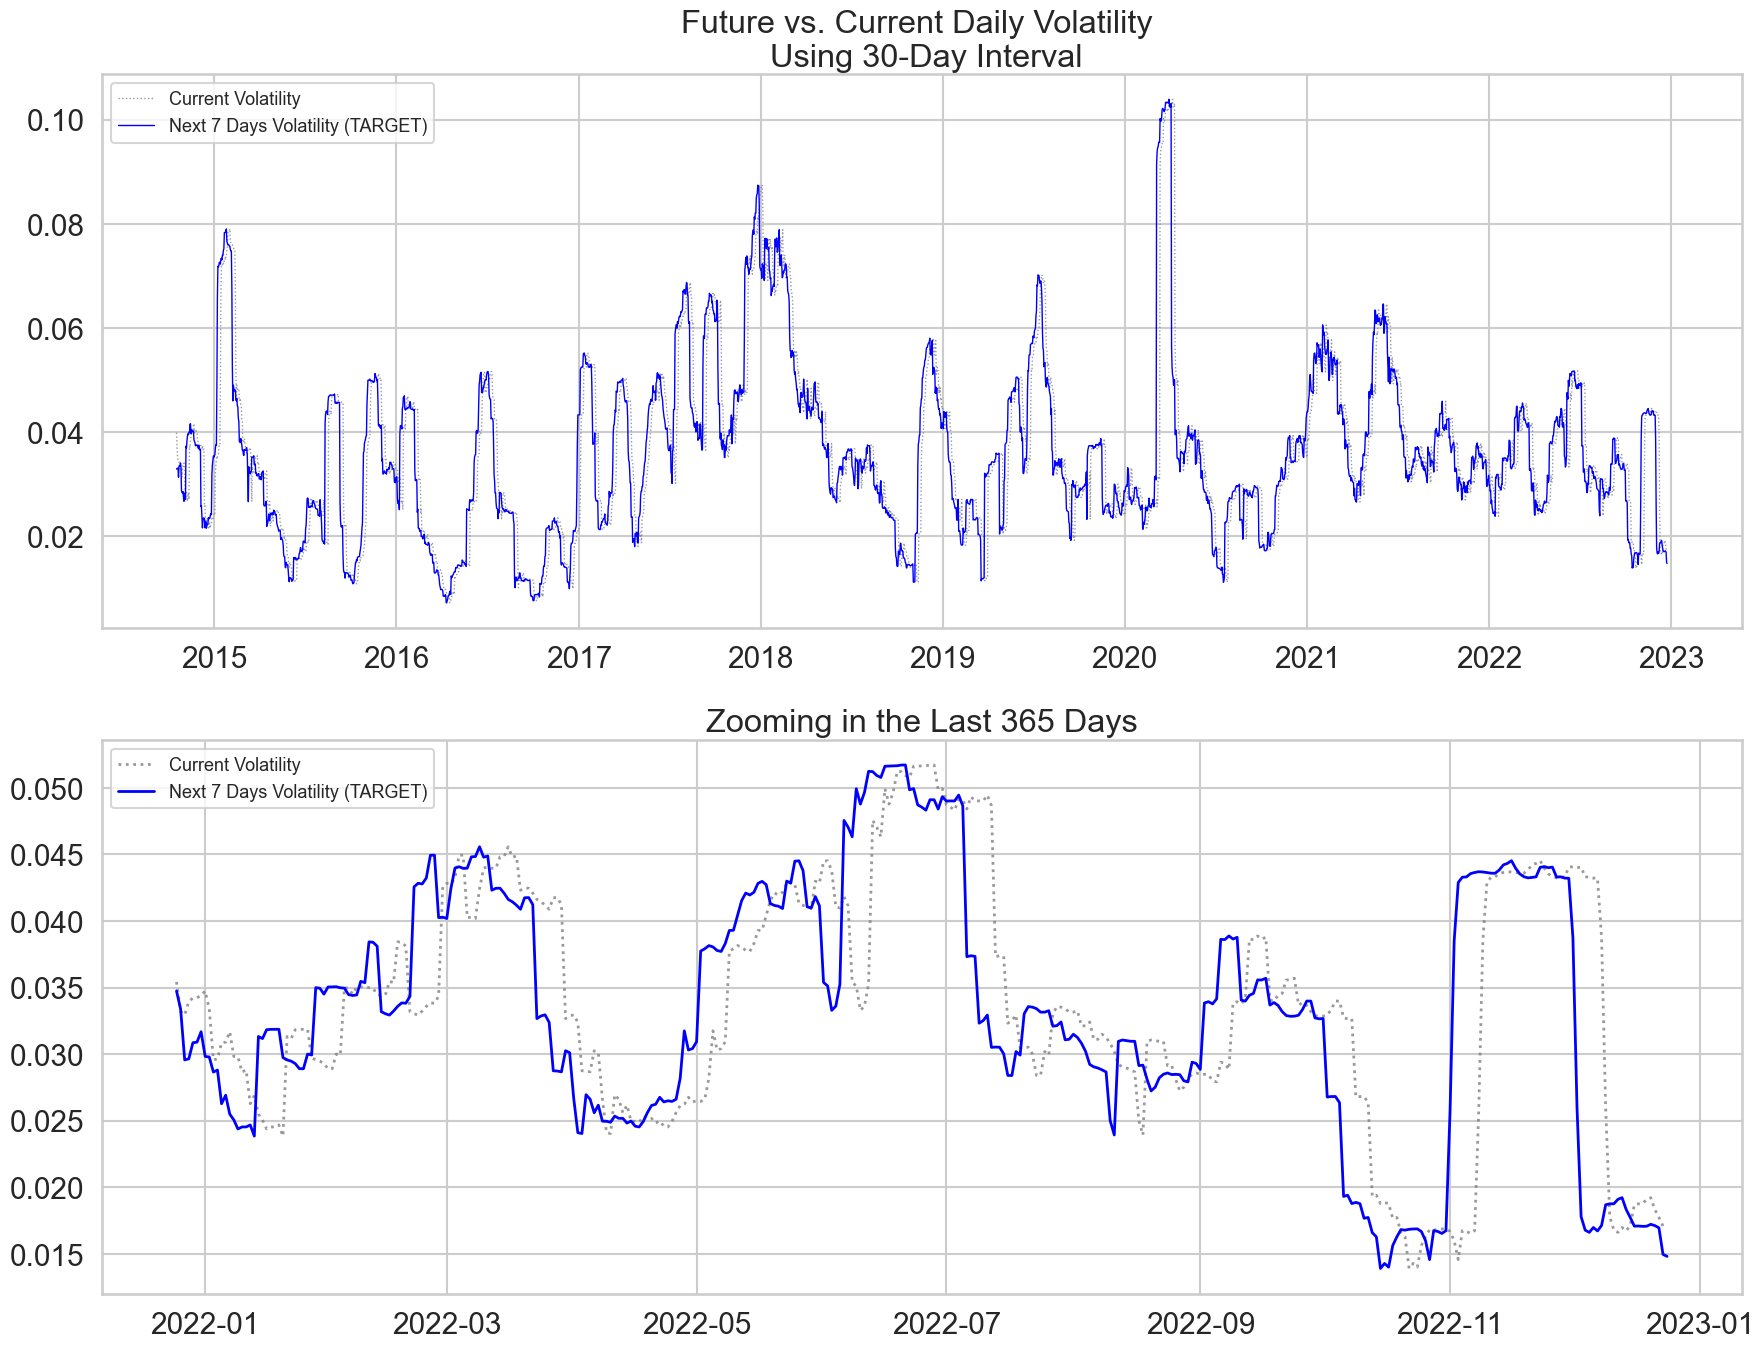

In [95]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.savefig(os.path.join('daily_vol.jpg'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In the plot above, the **blue line** indicates the **target future** value that I ultimately try to match up to. 

And the dotted **gray line** represents the **current volatility** in real-time. 

This is a visualization of how current volatility is shifted backward to become future values, which I want to eventually aim for. 

### **Daily Volatility Grouped by Month**

In [96]:
# RESETTING MATPLOTLIB STYLE TO DEFAULT
# plt.rcParams.update(plt.rcParamsDefault)

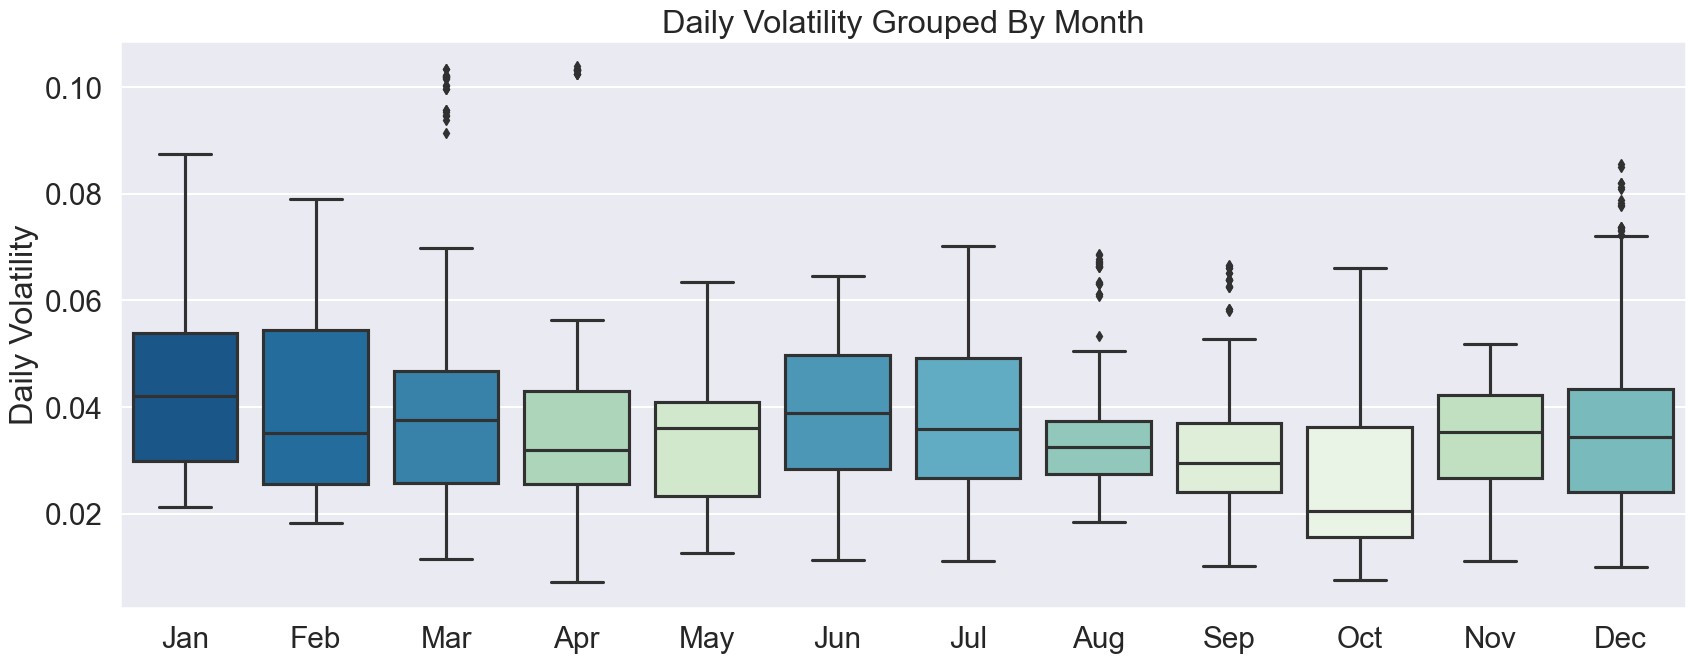

In [97]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()
# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]
# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))
# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')
    # sns.despine(bottom=False, left=False)
    plt.savefig(os.path.join( "vol_by_month.png"), dpi=300, bbox_inches='tight')
    plt.show()

In [98]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03

It can be observed that:
- volatility has consistently reached some of its higher points in the in the months of December/January historically 
- March and April has the most amount of large outliers 

- while August and September (which are the upcoming months I am going to forecast) historically has been relatively quiet

### **Daily Volatility Grouped by Year**

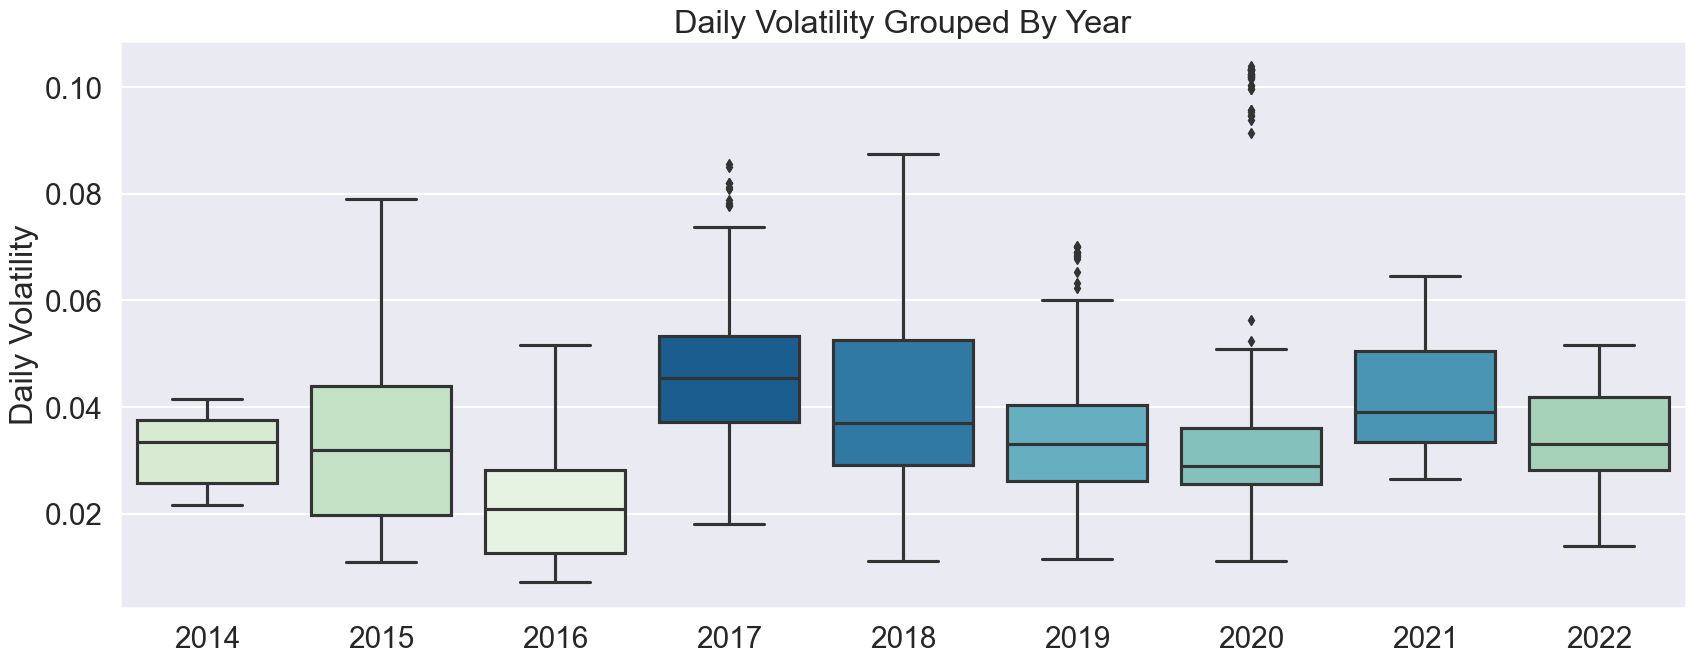

In [99]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()
# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))
# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.savefig(os.path.join( "vol_by_year.png"), dpi=300, bbox_inches='tight')
    plt.show()

This plot does reflect Bitcoin's first record peak in 2017 (around \$19,800 towards the end of December). And the outliers in 2020 corresponded with its over 200% surge in 2020 (Bitcoin started at \$7,200 at the beginning of 2020). It reached \$20,000 on most exchanges on 12/15/2020, and then proceeded to hit \$30,000 just 17 days later, which is no small feat. To put things in perspective, it took the Dow Jones close to 3 years to make the same move. And then, on 01/07/2021 it broke \$40,000.

And based on this, 2021's daily volatiliy overall has been on the higher side as well. 


### **Daily Volatility Distribution**

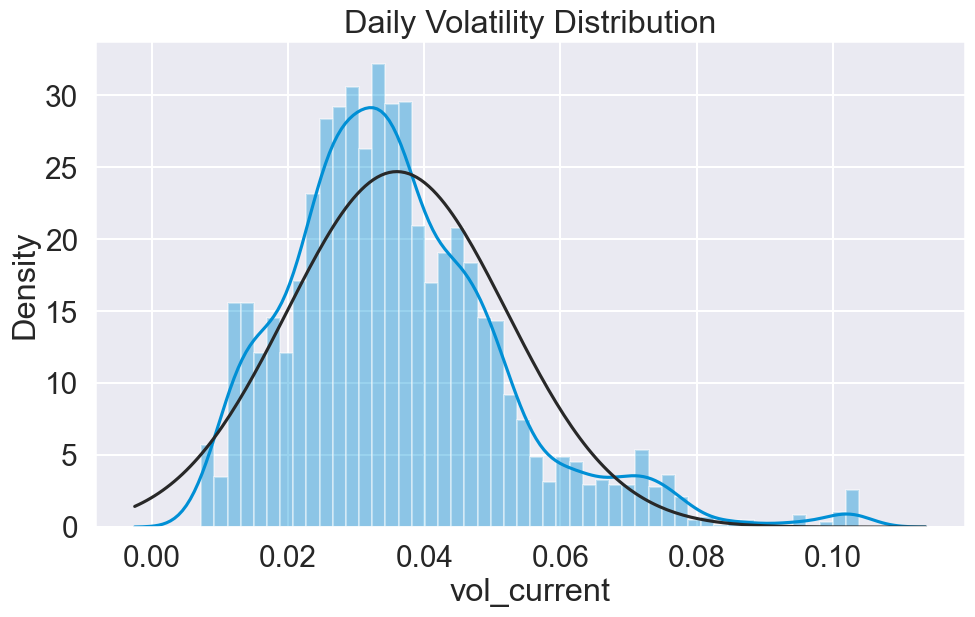

In [100]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.savefig(os.path.join("vol_dist.png"), dpi=300, bbox_inches='tight')
    plt.show();

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

### **Returns/Log Returns Stationarity Checking**



In [101]:
from statsmodels.tsa.stattools import adfuller

In [102]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -55.930141591125206
p-value: 0.0
Critical Values:
1%: -3.4325
5%: -2.8625
10%: -2.5673


In [103]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -55.93262152852236
p-value: 0.0
Critical Values:
1%: -3.4325
5%: -2.8625
10%: -2.5673


Using a significant level alpha of 0.05, `p-value` for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis. 

--> Returns and Log returns are both not dependent on time/trend

## **Train-Validation-Test Splits**

There're a total of 2500 usable datapoints in this dataset which covers a period of almost 7 years from October 2014 until today (end of August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for **Final Model Testing - approx. 1.2%**
- 1 full year (365 days) for **Validation** and **model tuning** during training **- approx. 14.7%**
- and the remaining for **Training - approx. 84.1%**




In [104]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [105]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2021-11-24 00:00:00+00:00 	2596 days
VALIDATION 	From: 2021-11-25 00:00:00+00:00 	to: 2022-11-24 00:00:00+00:00 	365 days
TEST 		From: 2022-11-25 00:00:00+00:00 	to: 2022-12-24 00:00:00+00:00 	30 days


The target here would be `vol_future` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - INTERVAL_WINDOW` to time step `t + n_future`). 

For example, using an `n_future` value of 7 and an `INTERVAL_WINDOW` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-23` to time step `t+7`.

In [106]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [107]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [108]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [109]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [110]:
y_train.describe()

count    2596.000000
mean        0.036299
std         0.016966
min         0.007228
25%         0.024757
50%         0.034047
75%         0.045631
max         0.103878
Name: vol_future, dtype: float64

In [111]:
x_train.describe()

count    2596.000000
mean        0.036313
std         0.016963
min         0.007228
25%         0.024757
50%         0.034113
75%         0.045631
max         0.103878
Name: vol_current, dtype: float64

## **Data Preprocessing**

### **Feature Normalization**

As I am going to build various types of models based on different algorithms using different types of inputs, it would be better to normalize the volatilities using `MinMaxScaler` to standardize the predictions generated among different models.

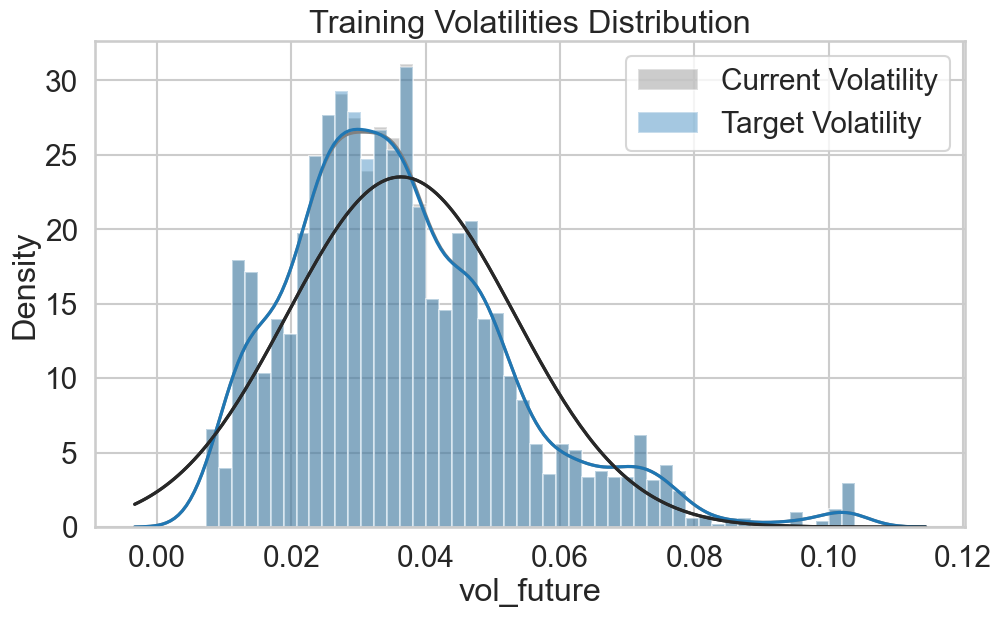

In [112]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.savefig(os.path.join("vol_dist.png"), dpi=300, bbox_inches='tight')
    plt.show();

In [113]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [114]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [115]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [116]:
x_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.039872
2014-10-18 00:00:00+00:00    0.037566
2014-10-19 00:00:00+00:00    0.035089
2014-10-20 00:00:00+00:00    0.034629
2014-10-21 00:00:00+00:00    0.034362
2014-10-22 00:00:00+00:00    0.034364
2014-10-23 00:00:00+00:00    0.033347
2014-10-24 00:00:00+00:00    0.032900
2014-10-25 00:00:00+00:00    0.033009
2014-10-26 00:00:00+00:00    0.033083
Name: vol_current, dtype: float64

In [117]:
y_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.032900
2014-10-18 00:00:00+00:00    0.033009
2014-10-19 00:00:00+00:00    0.033083
2014-10-20 00:00:00+00:00    0.033017
2014-10-21 00:00:00+00:00    0.031334
2014-10-22 00:00:00+00:00    0.033474
2014-10-23 00:00:00+00:00    0.033426
2014-10-24 00:00:00+00:00    0.033602
2014-10-25 00:00:00+00:00    0.034075
2014-10-26 00:00:00+00:00    0.033154
Name: vol_future, dtype: float64

In [118]:
x_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.337754
2014-10-18 00:00:00+00:00    0.313894
2014-10-19 00:00:00+00:00    0.288269
2014-10-20 00:00:00+00:00    0.283501
2014-10-21 00:00:00+00:00    0.280738
2014-10-22 00:00:00+00:00    0.280764
2014-10-23 00:00:00+00:00    0.270238
2014-10-24 00:00:00+00:00    0.265613
2014-10-25 00:00:00+00:00    0.266743
2014-10-26 00:00:00+00:00    0.267507
dtype: float64

In [119]:
y_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.265613
2014-10-18 00:00:00+00:00    0.266743
2014-10-19 00:00:00+00:00    0.267507
2014-10-20 00:00:00+00:00    0.266830
2014-10-21 00:00:00+00:00    0.249415
2014-10-22 00:00:00+00:00    0.271550
2014-10-23 00:00:00+00:00    0.271058
2014-10-24 00:00:00+00:00    0.272883
2014-10-25 00:00:00+00:00    0.277768
2014-10-26 00:00:00+00:00    0.268242
dtype: float64

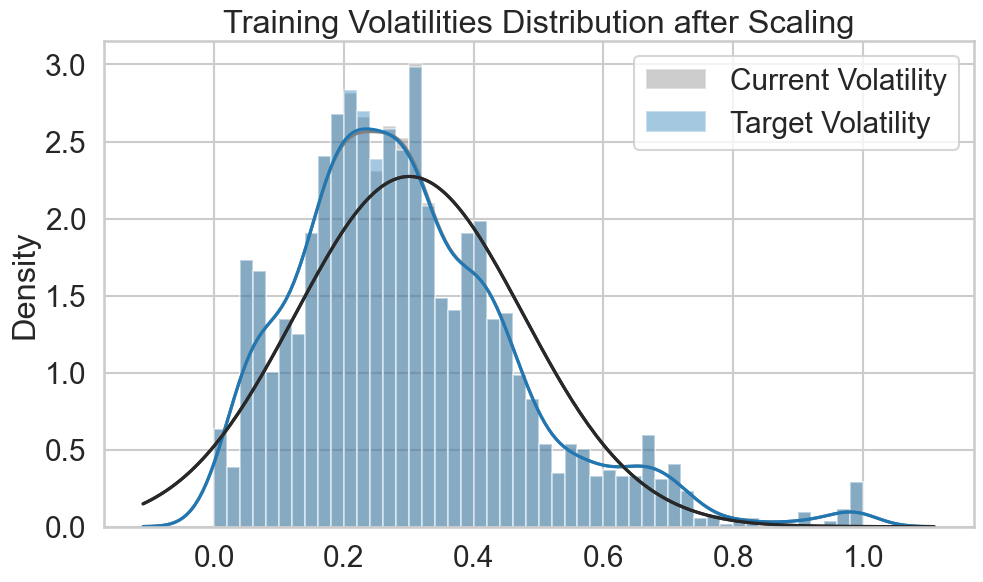

In [120]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.savefig(os.path.join("vol_dist_scaled.png"), 
                dpi=300, bbox_inches='tight')
    plt.show();

### **Train-Validation-Test Visualization**

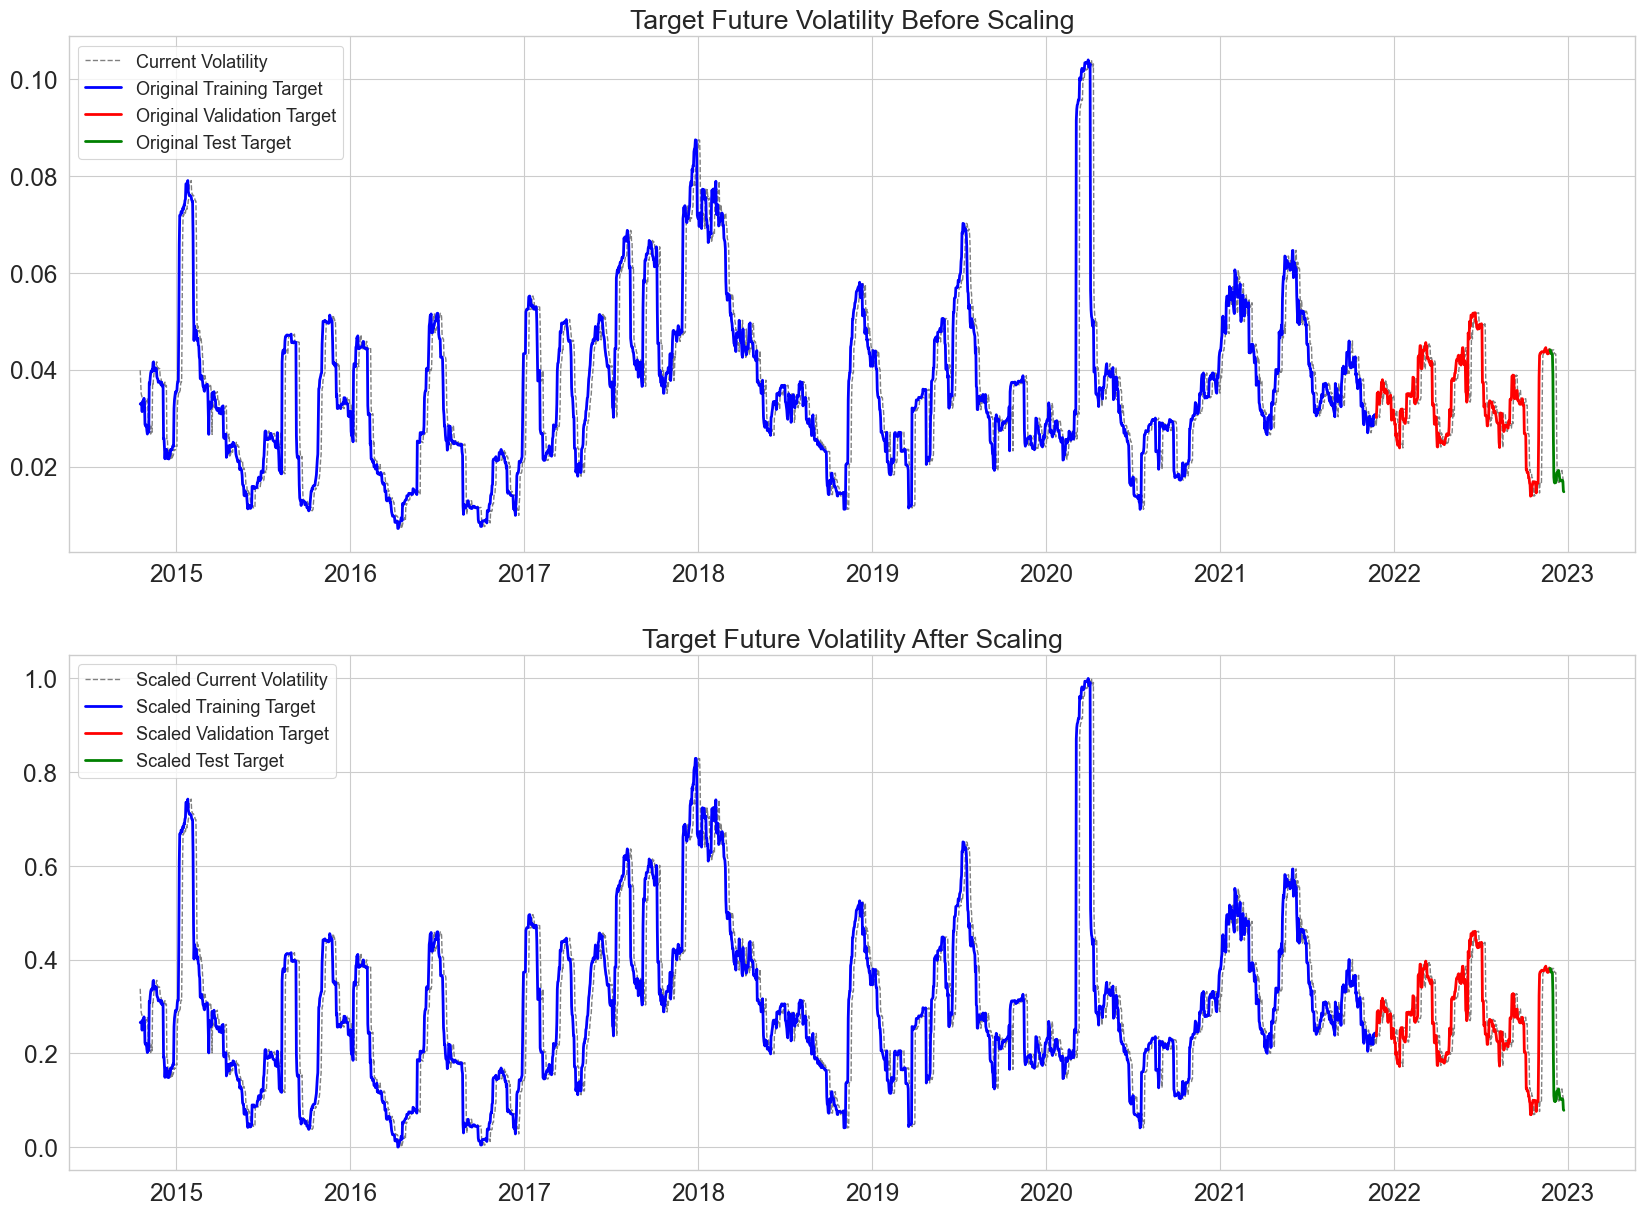

In [121]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='red', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='red', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.savefig(os.path.join('train_val_test_org_scled.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

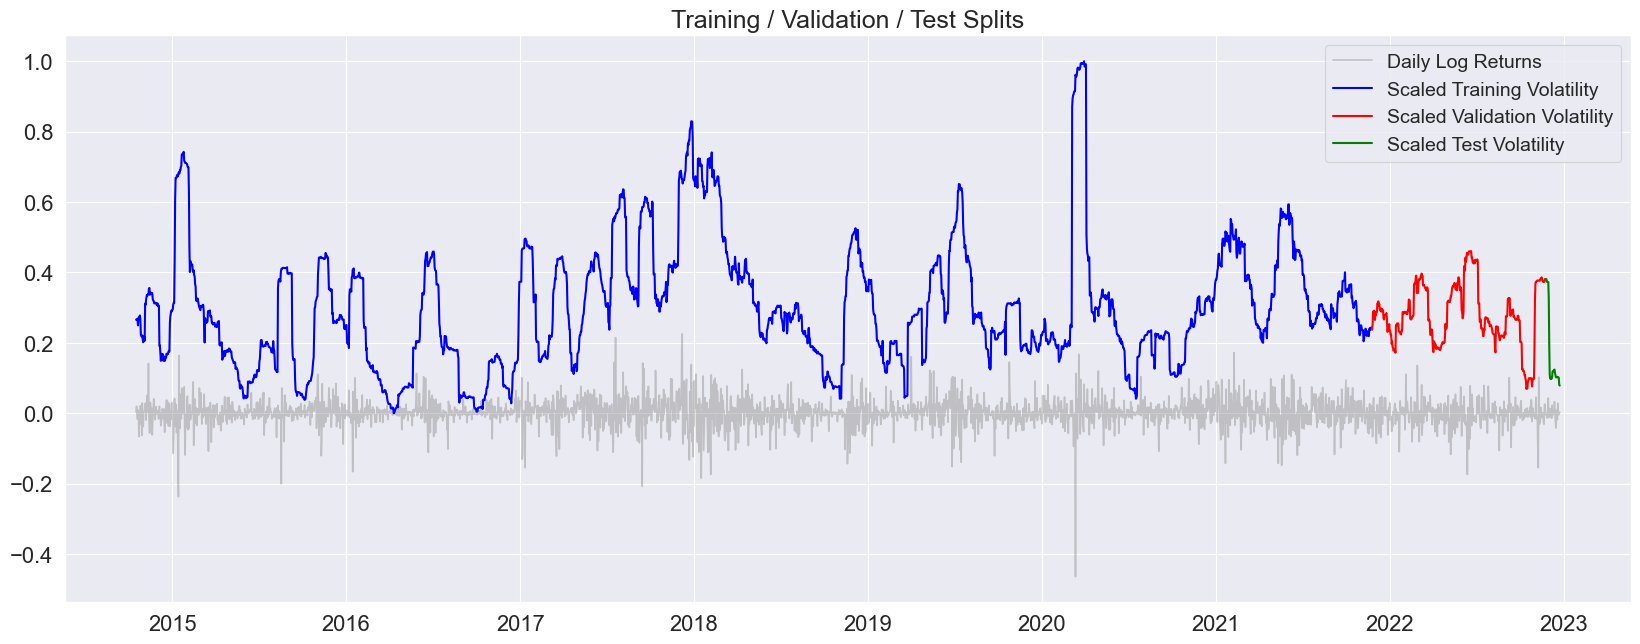

In [122]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=18)
    plt.legend(prop={'size': 14}, frameon=True)
    plt.savefig(os.path.join( 'train_val_test.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

# **MODELING**

## **Performance Metrics**

Usually with financial time series, if we just shift through the historic data trying different methods, parameters and timescales, it's almost certain to find to some strategy with in-sample profitability at some point. However the whole purpose of "forecasting" is to predict the future based on currently available information, and a model that performs best on training data might not be the best when it comes to out-of-sample generalization (or **overfitting**). Avoiding/Minimizing overfitting is even more important in the constantly evolving financial markets where the stake is high.

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Timescaling is very important in the calculation of volatility due to the level of freedom in frequency/interval window selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [123]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [124]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [125]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [126]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [127]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## **Model - TGARCH**

### **Basic GARCH**

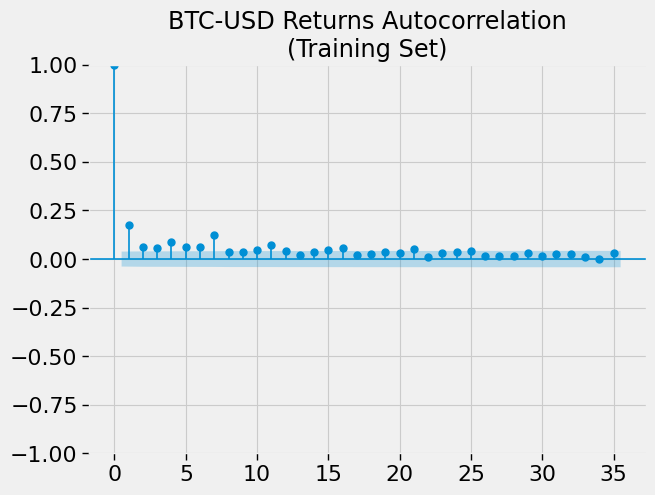

In [128]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

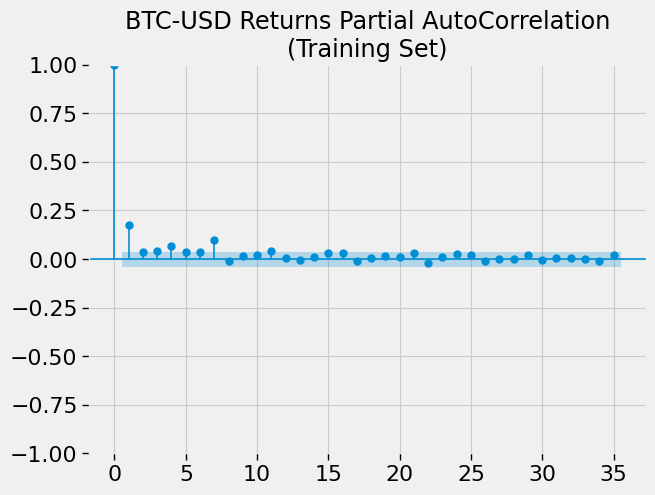

In [129]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. (One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timescale GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely).

In [130]:
from arch import arch_model

In [131]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1, o=1, power = 1.0, dist='skewt')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -6626.24
Distribution:      Standardized Skew Student's t   AIC:                           13266.5
Method:                       Maximum Likelihood   BIC:                           13307.5
                                                   No. Observations:                 2596
Date:                           Sun, Sep 03 2023   Df Residuals:                     2595
Time:                                   12:35:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------

All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. I am going to scale the fitted conditional volatility arrays, plot it out and compare it to the realized volatility calculated above (also scaled) `x_train_scaled`.

In [132]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [133]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [134]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

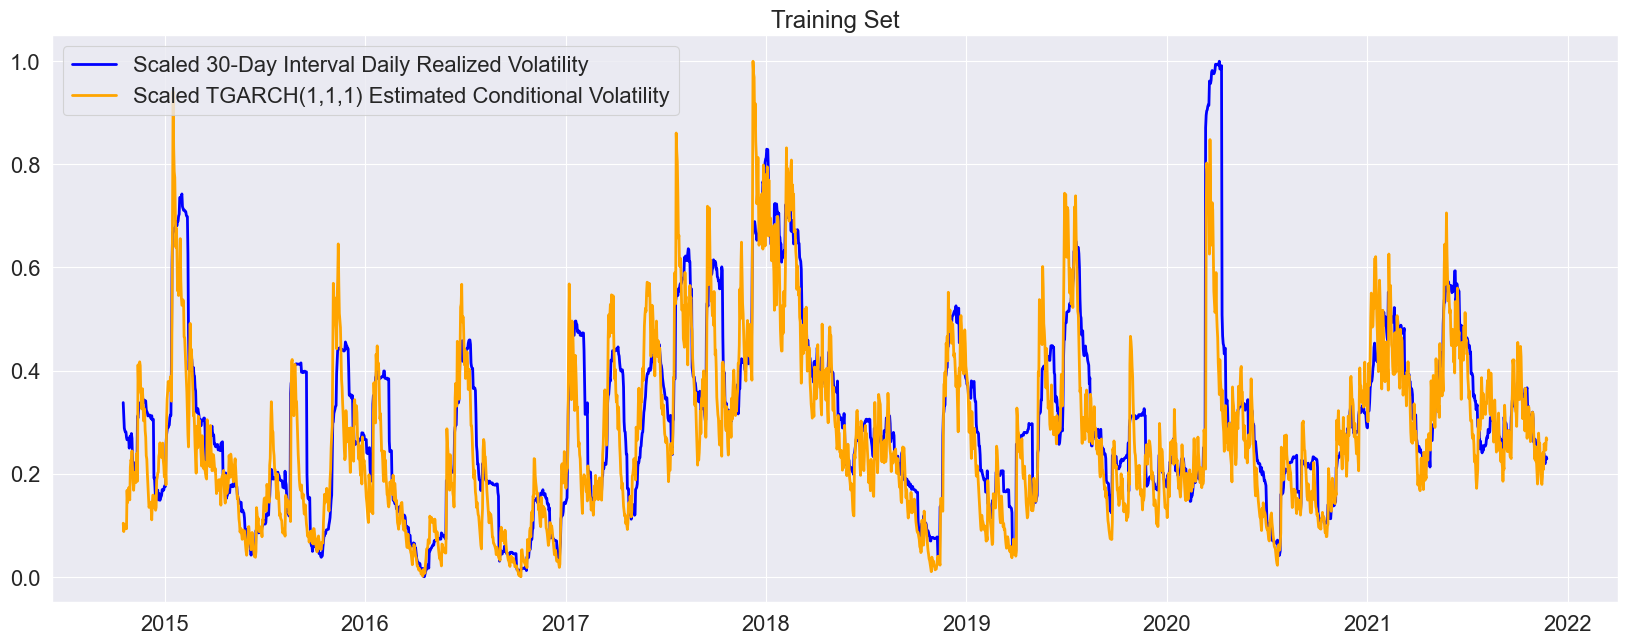

In [135]:
viz_cond_vol(scaled_cond_vol, 'TGARCH(1,1,1)')

#### **Analytical-based Forecasting**

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next `n_future` days. For example, to make prediction on `vol_future` at time step `t`, I would fit the model to all the `returns` available up to time step `t` and then obtain the average forecasted volatility for a horizon of `n_future = 7`.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

To generate predictions for the validation set, I will use one-step walk-forward forecasting, meaning for each time step I will retrain model using all the available datapoints that time step and then predict the following 7 days' volatilities.

In [136]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1, o=1, power = 1.0, dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=1, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

c:\Users\Xmoca\OneDrive\Desktop\virtual_envs_folder\thesis_venv\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


c:\Users\Xmoca\OneDrive\Desktop\virtual_envs_folder\thesis_venv\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Xmoca\OneDrive\Desktop\virtual_envs_folder\thesis_venv\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Xmoca\OneDrive\Desktop\virtual_envs_folder\thesis_venv\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Xmoca\OneDrive\Desktop\virtual_envs_folder\thesis_venv\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarni

In [137]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

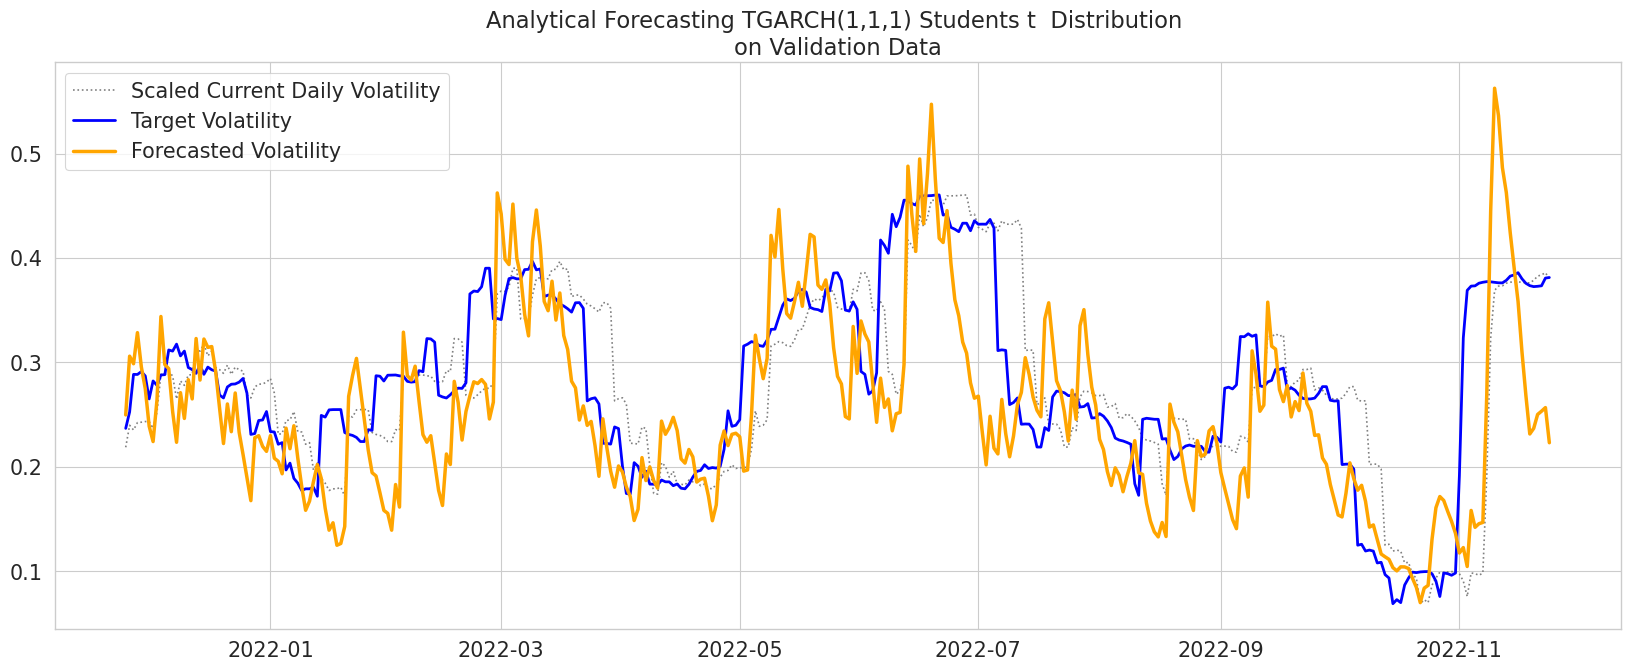

In [138]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting TGARCH(1,1,1) Student''s t  Distribution')

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [139]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'TGARCH(1,1,1), Constant Mean, T Dist')

Model  Validation RMSPE  Validation RMSE
0  TGARCH(1,1,1), Constant Mean, T Dist           0.26034         0.075596

Next, I would inspect the estimated residuals from this first GARCH model.

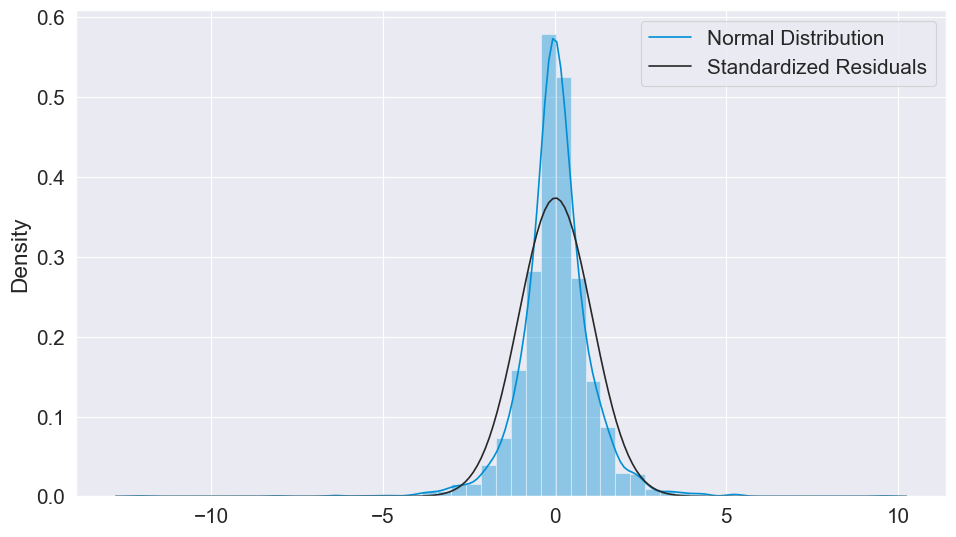

In [140]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

## **Model #4 - Neural Networks**

While GARCH remains the gold standard for volatility prediction within traditional financial institutions, there has been an increasing numbers of professionals and researchers turning to Machine Learning, especially Neural Networks, to gain insights into the financial markets in recent years.

(Reference: **Positional Option Trading** - Euan Sinclair)

Traders' theory of the market being inherently efficient (Efficient Market Hypothesis or EHM) states that share prices reflects all information and consistently outperforming the overall market is impossible. The more efficient a market is, the more random and unpredictable the returns will be, and thus **a perfectly efficient market will be completely unpredictable**. 

There are other arguments against EMH, and ones of the most prominent one is based on **Behavioral Finance**: compared to the human history of 200,000 years, the market has not been around for that long. For example, equity options have only been traded in liquid, transparent market since the CBOE opened in 1973; and the average lifetime of an S&P500 company is approx. 20 years. It means that some psychological tendencies of human beings have 200,000 years of evidence behind them, and that a lot of the movements of the markets that were driven by participants' behaviors will likely repeat itself at a later point. Therefore the market system cannot be totally random, it must have some patterns. Those patterns are extremely difficult to exploit due to the multitude of factors that interact and drive the market. 

Neural Networks would be a very good candidate for that.

In [141]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

In [142]:
# CONVERT INPUT & OUTPUT SERIES TO MATRIX DATASETS
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [143]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [144]:
def forecast(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    '''
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                    df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [145]:
def scale(scaler, y_series):
    '''
    Transform y_series using fitted scaler
    into another series with the same datetime index
    '''
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [146]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

## **Multivariate Networks**

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models seems failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is most likely not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [147]:
gm_1 = arch_model(df['log_returns'], vol='GARCH', p=1, q=1, o=1, power = 1.0, dist='skewt')
result_1 = gm_1.fit(disp='off')
rd = result_1.resid

In [148]:
df['TGARCH_residuals'] = rd

In [149]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                             Volume   returns  log_returns  vol_current  \
Date                                                                      
2014-10-17 00:00:00+00:00  13600700  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  11416800  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00   5914570 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16419000 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  14188900  0.948166     0.009437     0.034362   

                           vol_future  TGARCH_residuals  
Date                                                     
2014-10-17 00:00:00+00:00    0.032900          0.002119  
2014-10-18 00:00:00+00:00    0.033009          0.018807  
2014-10-19 00:00:00+00:00    0.033083         -0.005873  
2014-10-20 00:00:00+00:00    0.033017         -0.018369  
2014-10-21 00:00:00+00:00    0.031334          0.008419

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2014-10-17 00:00:00+00:00 to 2022-12-24 00:00:00+00:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              2991 non-null   float64
 1   High              2991 non-null   float64
 2   Low               2991 non-null   float64
 3   Close             2991 non-null   float64
 4   Volume            2991 non-null   int64  
 5   returns           2991 non-null   float64
 6   log_returns       2991 non-null   float64
 7   vol_current       2991 non-null   float64
 8   vol_future        2991 non-null   float64
 9   TGARCH_residuals  2991 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 321.6 KB


In [151]:
df.describe()

Open          High           Low         Close        Volume  \
count   2991.000000   2991.000000   2991.000000   2991.000000  2.991000e+03   
mean   12974.395060  13302.398102  12607.422160  12978.378109  1.651291e+10   
std    16240.715153  16656.528426  15759.217998  16235.677760  2.003042e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      707.809509    717.733002    699.855499    710.684998  1.108810e+08   
50%     7179.283203   7335.290039   6984.069824   7191.158691  7.652090e+09   
75%    16913.985352  17231.230469  16578.150391  16922.518555  2.816441e+10   
max    67549.734375  68789.625000  66382.062500  67566.828125  3.509679e+11   

           returns  log_returns  vol_current   vol_future  TGARCH_residuals  
count  2991.000000  2991.000000  2991.000000  2991.000000       2991.000000  
mean      0.200927     0.001265     0.035972     0.035927          0.000248  
std       3.836216     0.038693     0.016149     0.016177          0.038693  
min     -37.169539    -0.464730     0.007228     0.007228         -0.465748  
25%      -1.351716    -0.013609     0.025272     0.025216         -0.014627  
50%       0.180278     0.001801     0.033873     0.033802          0.000783  
75%       1.773910     0.017584     0.044430     0.044430          0.016566  
max      25.247169     0.225119     0.103878     0.103878          0.224101

### Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would only extract information to create 2 more features:
- **High-Low Spread** - which is the logarithm of the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- **Open-Close Spread** - which is the difference between the Close and Open prices intraday as a percentage of the Closing price

and then for Volume:
- Volume column has very large values that are billions/millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

In [152]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [153]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-10-17 00:00:00+00:00  382.756012  385.477997  375.389008  383.757996   
2014-10-18 00:00:00+00:00  383.976013  395.157990  378.971008  391.441986   
2014-10-19 00:00:00+00:00  391.253998  393.938995  386.457001  389.545990   
2014-10-20 00:00:00+00:00  389.230988  390.084015  378.252014  382.845001   
2014-10-21 00:00:00+00:00  382.420990  392.645996  380.834015  386.475006   

                              Volume   returns  log_returns  vol_current  \
Date                                                                       
2014-10-17 00:00:00+00:00  16.425632  0.314201     0.003137     0.039872   
2014-10-18 00:00:00+00:00  16.250597  2.002301     0.019825     0.037566   
2014-10-19 00:00:00+00:00  15.592929 -0.484362    -0.004855     0.035089   
2014-10-20 00:00:00+00:00  16.613950 -1.720205    -0.017352     0.034629   
2014-10-21 00:00:00+00:00  16.467971  0.948166     0.009437     0.034362   

                           vol_future  TGARCH_residuals   HL_sprd   CO_sprd  
Date                                                                         
2014-10-17 00:00:00+00:00    0.032900          0.002119 -3.638567  0.002618  
2014-10-18 00:00:00+00:00    0.033009          0.018807 -3.185630  0.019444  
2014-10-19 00:00:00+00:00    0.033083         -0.005873 -3.952483 -0.004365  
2014-10-20 00:00:00+00:00    0.033017         -0.018369 -3.476822 -0.016407  
2014-10-21 00:00:00+00:00    0.031334          0.008419 -3.487953  0.010601

These numeric features will need to be normalized since LSTM uses `sigmoid` and `tanh` activation functions, which is very sensitive magnitude.

Since `vol_current` is already derived from `log_returns`, I am not going to include `log_returns` in my model.

In [154]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current', 'TGARCH_residuals']

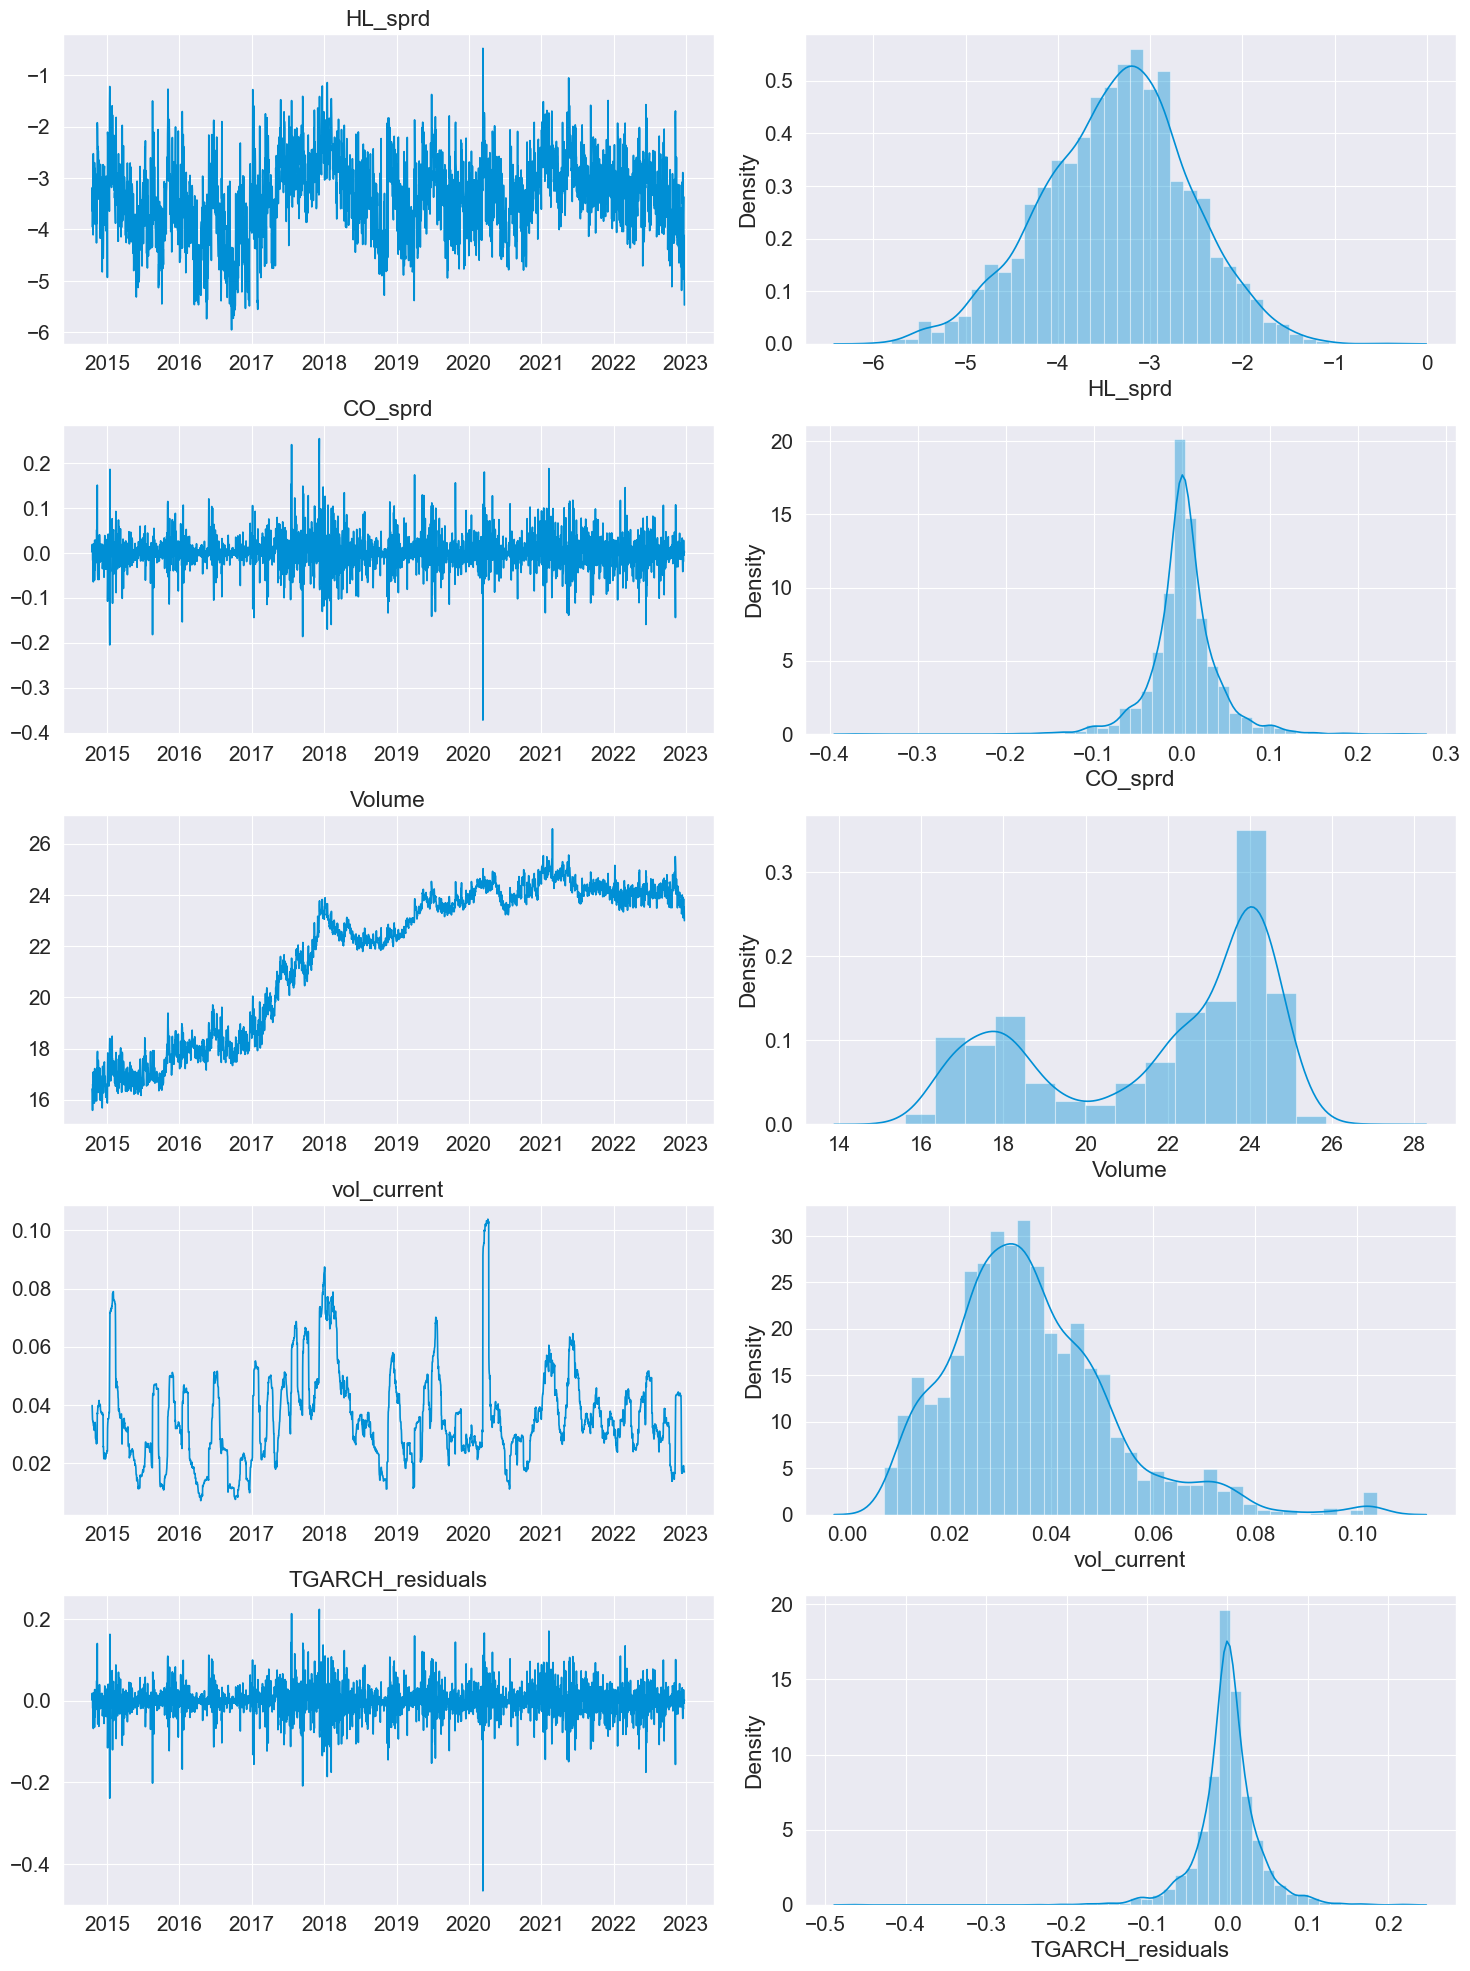

In [155]:
# PLOT EACH NUMERICAL COLUMN
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,20))

    for i, c in enumerate(features):
        ax1, ax2 = axes[i][0], axes[i][1]
        ax1.plot(df[c])
        ax1.set_title(c)

        sns.distplot(df[c], ax=ax2)

    plt.tight_layout()

    plt.show();

In [156]:
# PRINT OUT FIRST 5 ROWS OF INPUT DATAFRAME
input_df = df[features]

# SEPARATE TRAINING INPUT
X_train = input_df.loc[train_idx]

In [157]:
X_train.head()

HL_sprd   CO_sprd     Volume  vol_current  \
Date                                                                    
2014-10-17 00:00:00+00:00 -3.638567  0.002618  16.425632     0.039872   
2014-10-18 00:00:00+00:00 -3.185630  0.019444  16.250597     0.037566   
2014-10-19 00:00:00+00:00 -3.952483 -0.004365  15.592929     0.035089   
2014-10-20 00:00:00+00:00 -3.476822 -0.016407  16.613950     0.034629   
2014-10-21 00:00:00+00:00 -3.487953  0.010601  16.467971     0.034362   

                           TGARCH_residuals  
Date                                         
2014-10-17 00:00:00+00:00          0.002119  
2014-10-18 00:00:00+00:00          0.018807  
2014-10-19 00:00:00+00:00         -0.005873  
2014-10-20 00:00:00+00:00         -0.018369  
2014-10-21 00:00:00+00:00          0.008419

In [158]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2014-10-17 00:00:00+00:00 to 2022-12-24 00:00:00+00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HL_sprd           2991 non-null   float64
 1   CO_sprd           2991 non-null   float64
 2   Volume            2991 non-null   float64
 3   vol_current       2991 non-null   float64
 4   TGARCH_residuals  2991 non-null   float64
dtypes: float64(5)
memory usage: 204.7 KB


In [159]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2596 entries, 2014-10-17 00:00:00+00:00 to 2021-11-24 00:00:00+00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HL_sprd           2596 non-null   float64
 1   CO_sprd           2596 non-null   float64
 2   Volume            2596 non-null   float64
 3   vol_current       2596 non-null   float64
 4   TGARCH_residuals  2596 non-null   float64
dtypes: float64(5)
memory usage: 121.7 KB


In [160]:
def forecast_multi(model, range_idx):
    '''
    Generate predictions for a time period 'range_idx' 
    using fitted 'model' with 'n_past' value preassigned
    for Multivariate LSTM
    '''
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

# **LSTM-GARCH**

In [161]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 5)             20        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 256)           137216    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [162]:
# FITTING TO TRAINING DATA
lstm_res = lstm.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

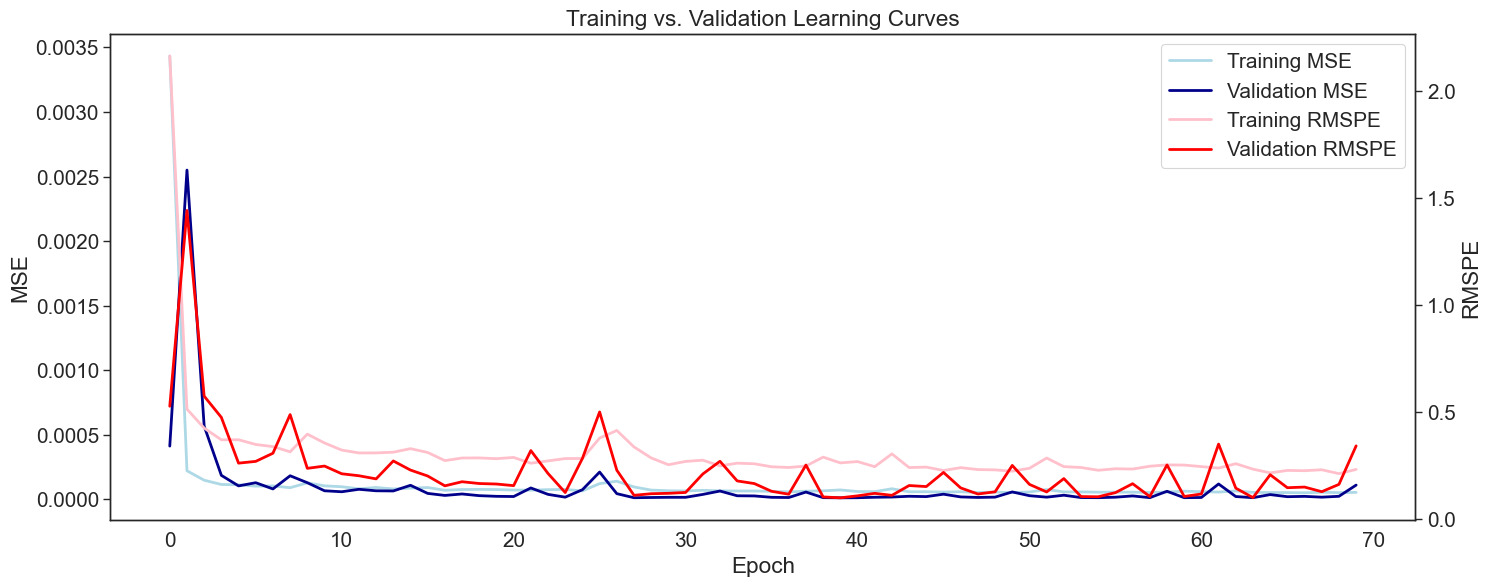

In [163]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_res)

In [164]:
# FORECASTING ON VALIDATION SET
lstm_preds = forecast_multi(lstm, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_preds_scaled = scale(scaler_vol, lstm_preds)

12/12 [==============================] - 5s 18ms/step


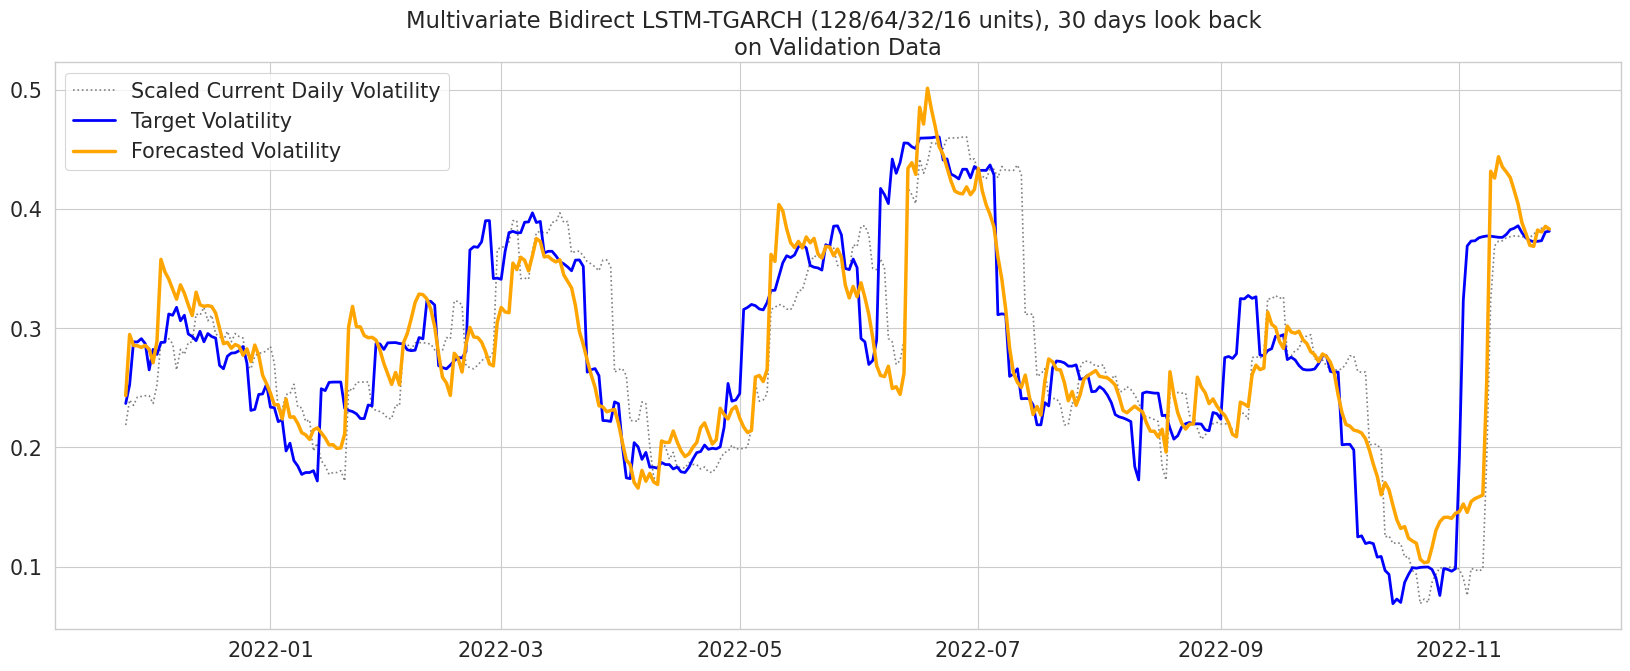

In [165]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_preds_scaled, 
          f"Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), {n_past} days look back")
plt.savefig('lstm_TGARCH_preds.png', dpi=300, bbox_inches='tight')
plt.show();

In [166]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_preds_scaled, 
         f"Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0           0.26034         0.075596  
1           0.21739         0.051033

# **GRU-GARCH**

In [167]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model

In [168]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
gru_model = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

gru_model.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('gru_model.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(gru_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 5)             20        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 256)           103680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           123648    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [169]:
# FITTING TO TRAINING DATA
gru_model_res = gru_model.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

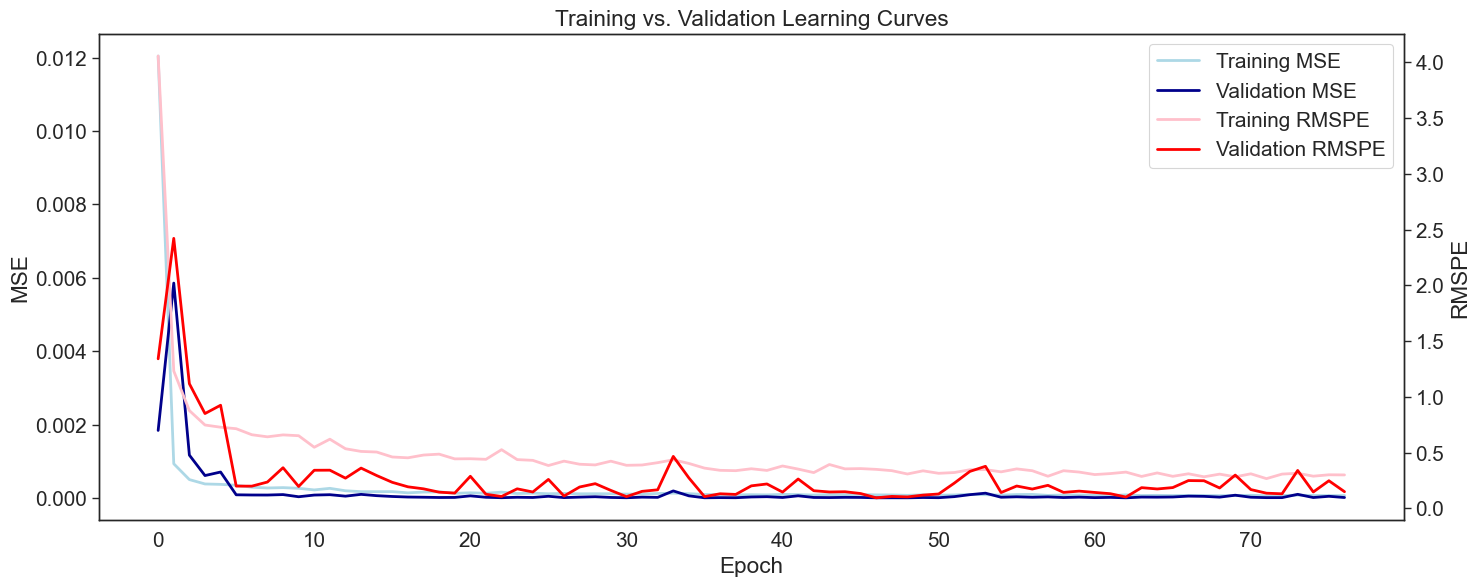

In [170]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(gru_model_res)

In [171]:
# FORECASTING ON VALIDATION SET
gru_model_preds = forecast_multi(gru_model, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
gru_model_preds_scaled = scale(scaler_vol, gru_model_preds)

12/12 [==============================] - 11s 17ms/step


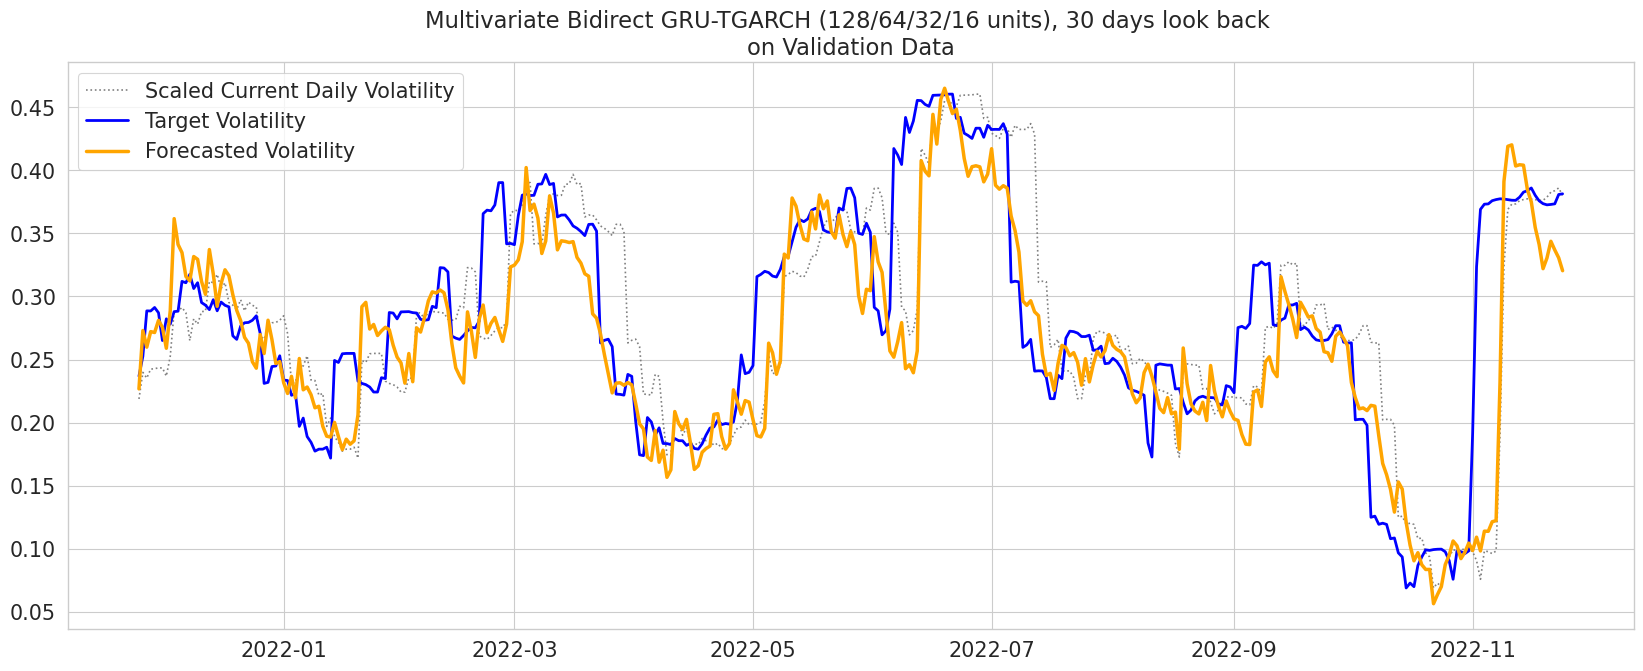

In [172]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gru_model_preds_scaled, 
          f"Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), {n_past} days look back")
plt.savefig('gru_model_TGARCH_preds.png', dpi=300, bbox_inches='tight')
plt.show();

In [173]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gru_model_preds_scaled, 
         f"Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   
2   Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          0.260340         0.075596  
1          0.217390         0.051033  
2          0.194446         0.055911

# **FNN GARCH**

In [174]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]


mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# Create the FNN model
fnn_model_multi = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, n_dims]),
    tf.keras.layers.Dense(128, activation='relu'),  # 128 neurons with ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),   # 64 neurons with ReLU activation
    tf.keras.layers.Dense(32, activation='relu'),   # 32 neurons with ReLU activation
    tf.keras.layers.Dense(16, activation='relu'),   # 16 neurons with ReLU activation
    tf.keras.layers.Dense(1)  # Output layer
])

fnn_model_multi.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])

print(fnn_model_multi.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 128)               19328     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30209 (118.00 KB)
Trainable params: 30209 

In [175]:
# FITTING TO TRAINING DATA
fnn_model_multi_res = fnn_model_multi.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

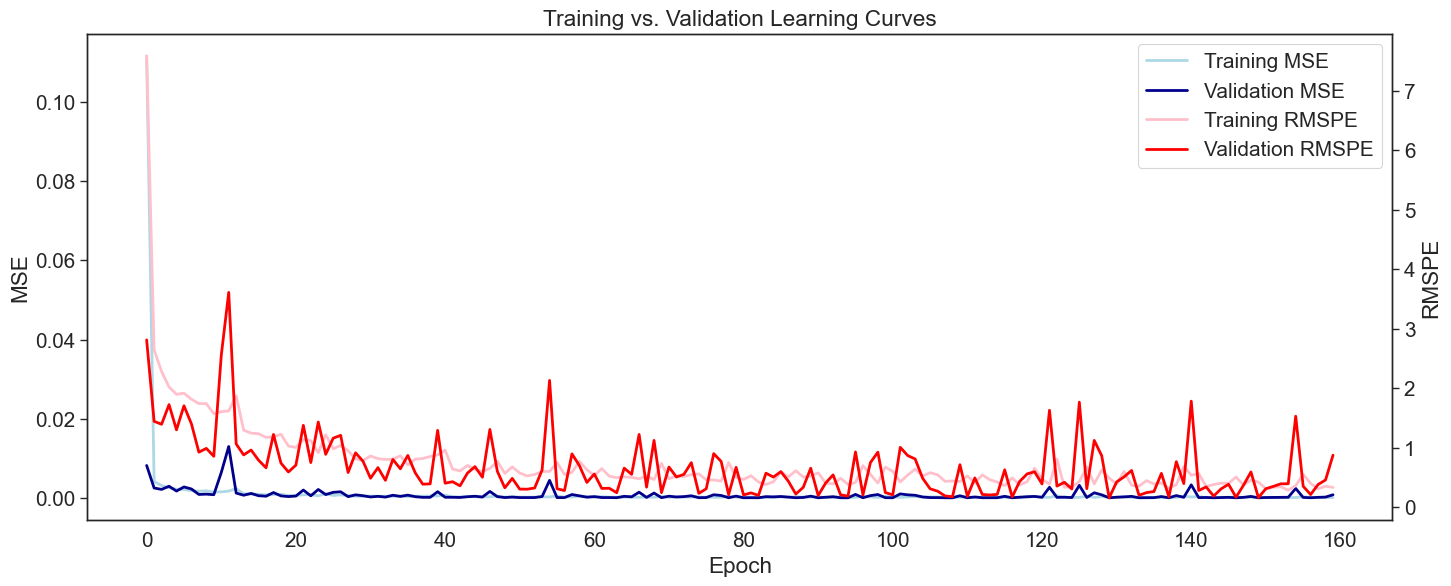

In [176]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(fnn_model_multi_res)

In [177]:
# FORECASTING ON VALIDATION SET
fnn_model_multi_preds = forecast_multi(fnn_model_multi, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
fnn_model_multi_preds_scaled = scale(scaler_vol, fnn_model_multi_preds)

12/12 [==============================] - 0s 2ms/step


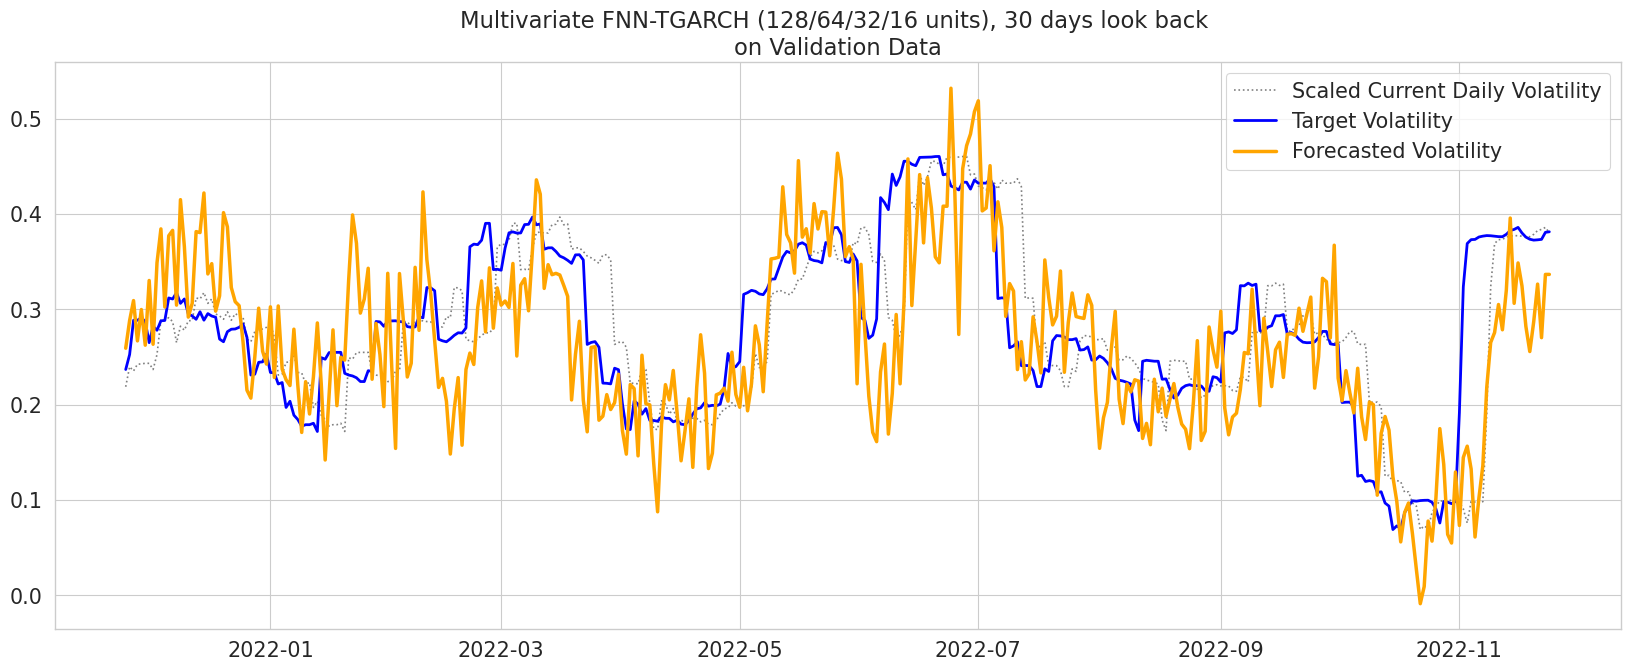

In [178]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, fnn_model_multi_preds_scaled, 
          f"Multivariate FNN-TGARCH (128/64/32/16 units), {n_past} days look back")
plt.savefig('fnn_multi_TGARCH_preds.png', dpi=300, bbox_inches='tight')
plt.show();

In [179]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, fnn_model_multi_preds_scaled, 
         f"Multivariate FNN-TGARCH (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   
2   Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past=30, batch=64   
3            Multivariate FNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          0.260340         0.075596  
1          0.217390         0.051033  
2          0.194446         0.055911  
3          0.286206         0.073471

# **RNN GARCH**

In [180]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]


mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# Create the RNN model
rnn_model_multi = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', return_sequences=True, input_shape=(n_past, n_dims)),
    tf.keras.layers.SimpleRNN(64, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='relu', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='relu', return_sequences=False),  # return_sequences=False for the last layer
    tf.keras.layers.Dense(1)
])

rnn_model_multi.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])

print(rnn_model_multi.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 128)           17152     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 64)            12352     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 32)            3104      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 33409 (130.50 KB)
Trainable params: 33409 (130.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [181]:
# FITTING TO TRAINING DATA
rnn_model_multi_res = rnn_model_multi.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

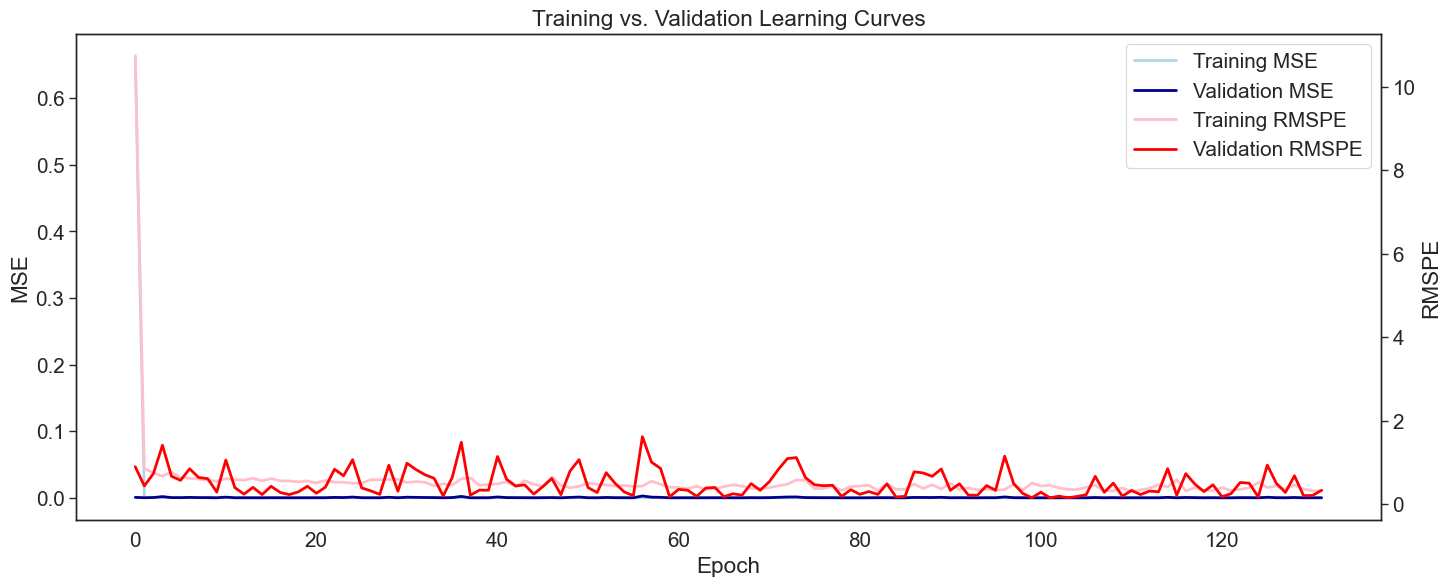

In [182]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(rnn_model_multi_res)

In [183]:
# FORECASTING ON VALIDATION SET
rnn_model_multi_preds = forecast_multi(rnn_model_multi, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
rnn_model_multi_preds_scaled = scale(scaler_vol, rnn_model_multi_preds)

12/12 [==============================] - 1s 5ms/step


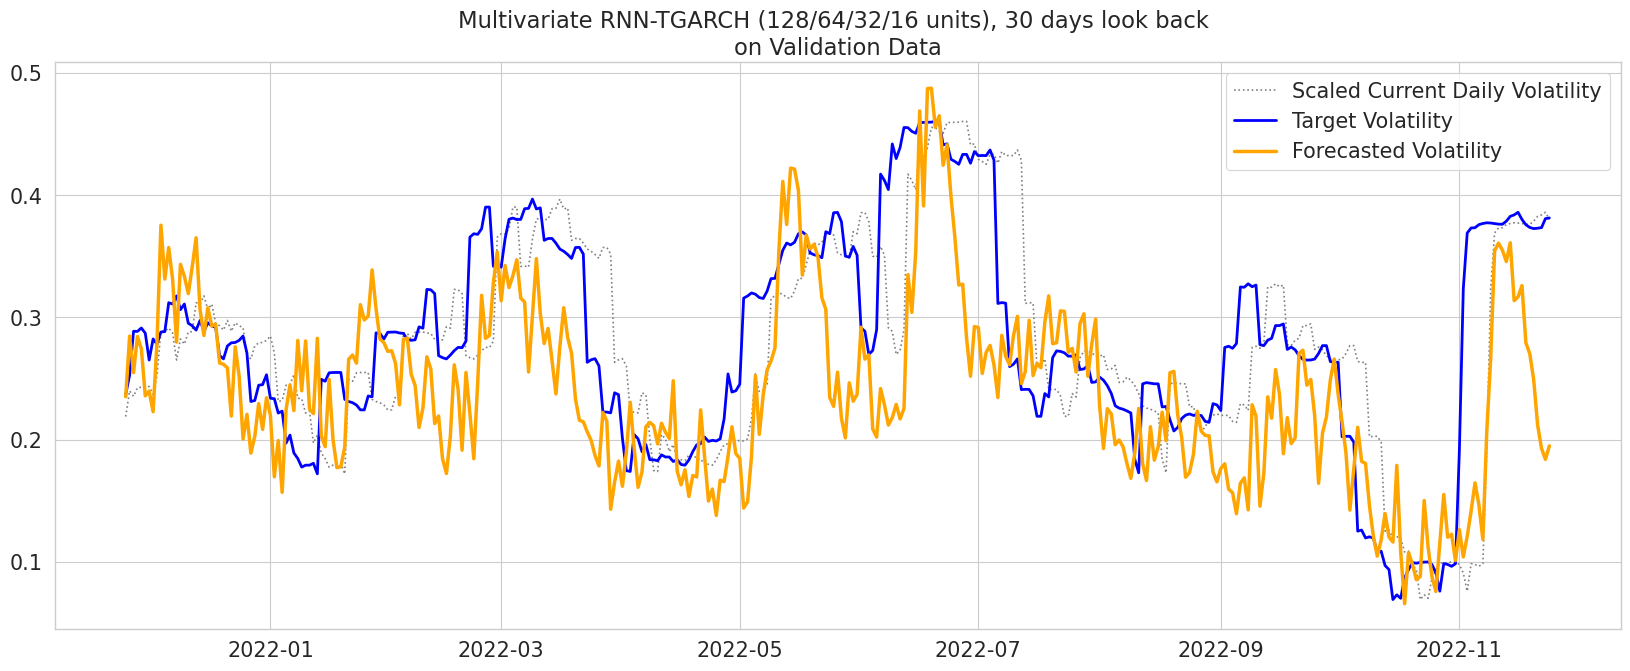

In [184]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, rnn_model_multi_preds_scaled, 
          f"Multivariate RNN-TGARCH (128/64/32/16 units), {n_past} days look back")
plt.savefig('rnn_multi_TGARCH_preds.png', dpi=300, bbox_inches='tight')
plt.show();

In [185]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, rnn_model_multi_preds_scaled, 
         f"Multivariate RNN-TGARCH (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   
2   Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past=30, batch=64   
3            Multivariate FNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   
4            Multivariate RNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          0.260340         0.075596  
1          0.217390         0.051033  
2          0.194446         0.055911  
3          0.286206         0.073471  
4          0.272142         0.080651

# **CNN GARCH**

In [186]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]


mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# Create the CNN model
cnn_model_multi = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_past, n_dims)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

cnn_model_multi.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])

print(cnn_model_multi.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 128)           1408      
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 32)             4128      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 32)             0

In [187]:
# FITTING TO TRAINING DATA
cnn_model_multi_res = cnn_model_multi.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

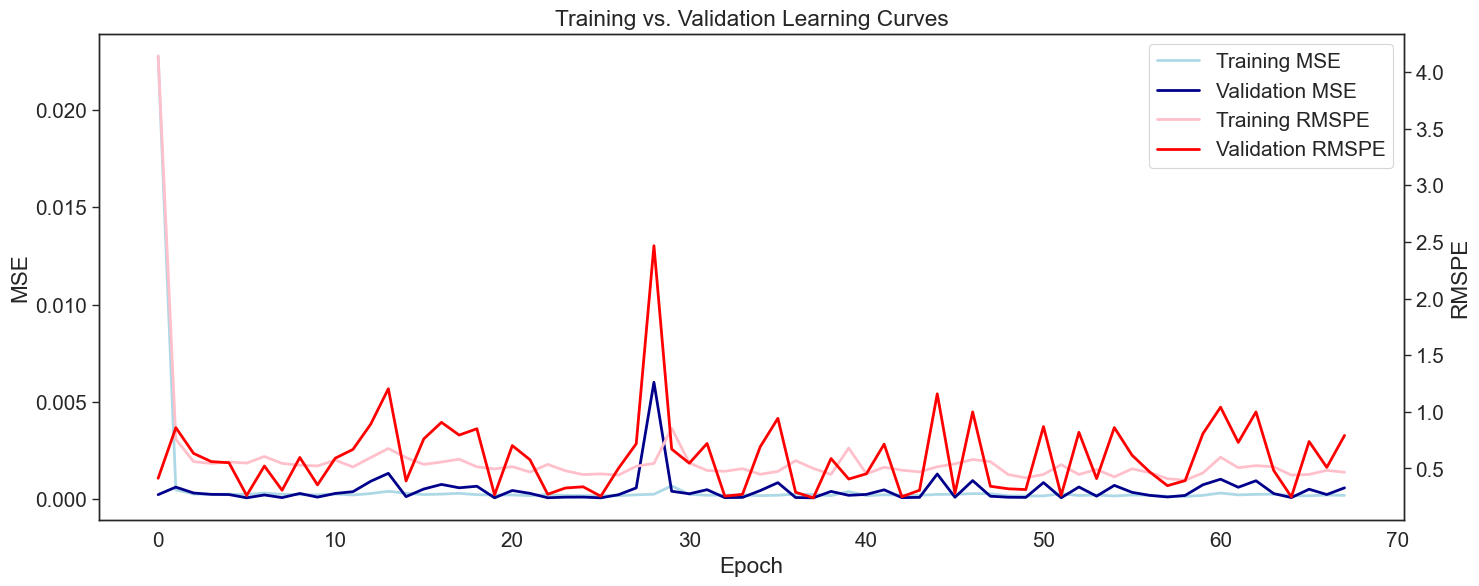

In [188]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(cnn_model_multi_res)

In [189]:
# FORECASTING ON VALIDATION SET
cnn_model_multi_preds = forecast_multi(cnn_model_multi, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
cnn_model_multi_preds_scaled = scale(scaler_vol, cnn_model_multi_preds)

12/12 [==============================] - 0s 2ms/step


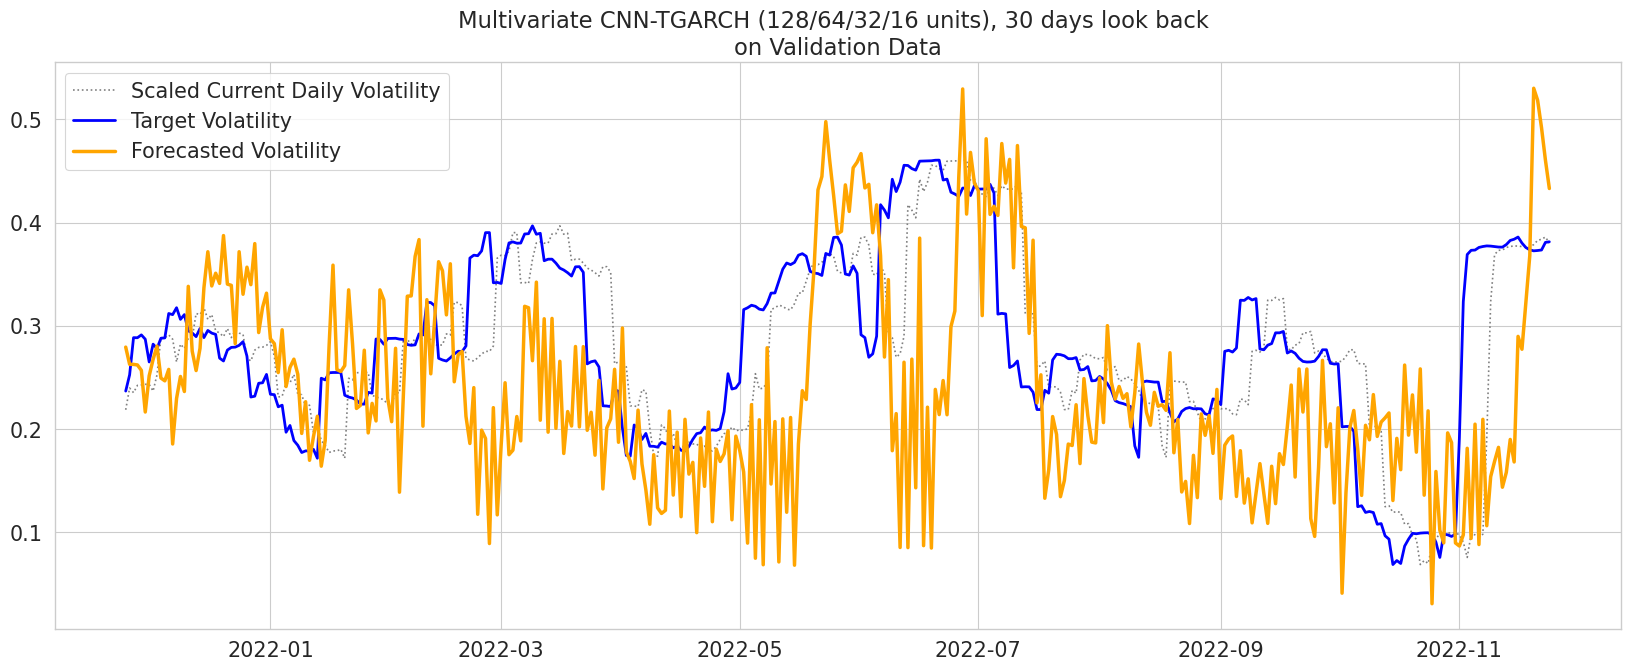

In [190]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, cnn_model_multi_preds_scaled, 
          f"Multivariate CNN-TGARCH (128/64/32/16 units), {n_past} days look back")
plt.savefig('cnn_multi_TGARCH_preds.png', dpi=300, bbox_inches='tight')
plt.show();

In [191]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, cnn_model_multi_preds_scaled, 
         f"Multivariate CNN-TGARCH (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   
2   Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past=30, batch=64   
3            Multivariate FNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   
4            Multivariate RNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   
5            Multivariate CNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          0.260340         0.075596  
1          0.217390         0.051033  
2          0.194446         0.055911  
3          0.286206         0.073471  
4          0.272142         0.080651  
5          0.441380         0.118010

### **Final Model**

For this final model, I'll re-create the same architecture as model #19 (Multivariate Bidirectional LSTM with 3 layers of 64/32/16 units) and a lookback window `n_past = 30` and `batch_size = 64` as mentioned above. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

In [192]:
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [193]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 30, 5)             20        
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           35840     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [194]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

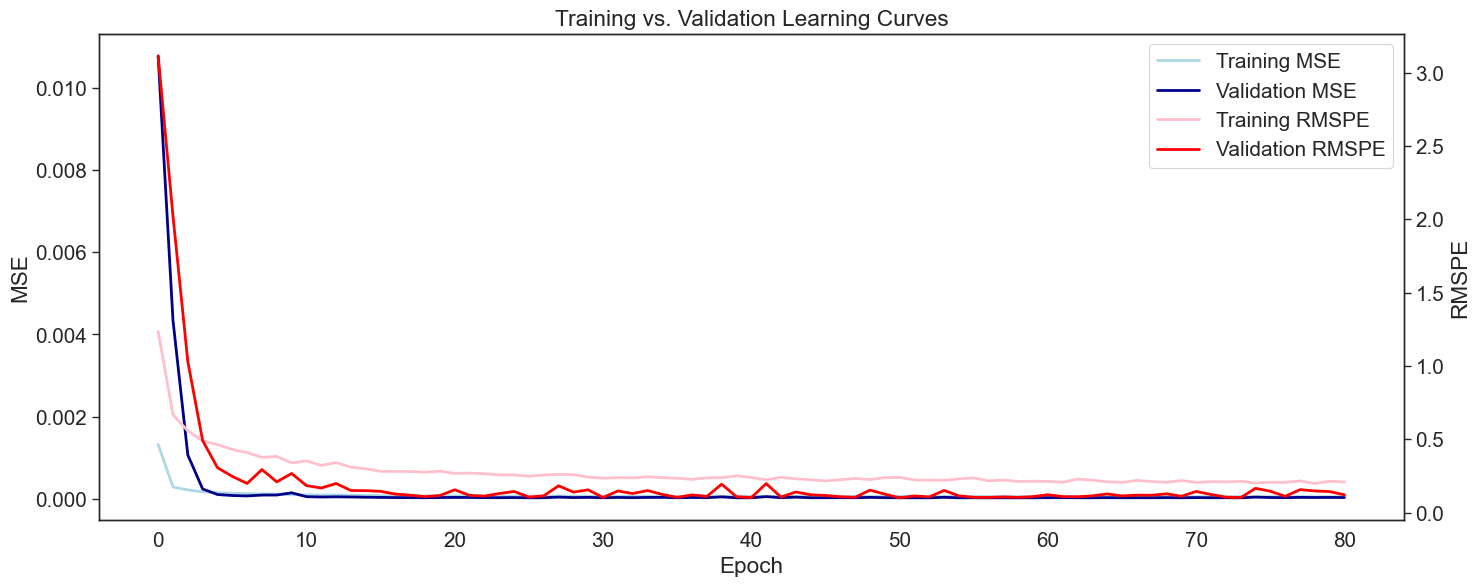

In [195]:
viz_train_val_metrics(lstm_final_res)

Validation Learning Curves look quite unstable.

In [196]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

1/1 [==============================] - 3s 3s/step


In [197]:
y_test_preds.describe()

count    30.000000
mean      0.025489
std       0.010361
min       0.015528
25%       0.017440
50%       0.021408
75%       0.033123
max       0.045574
dtype: float64

In [198]:
y_test.describe()

count    30.000000
mean      0.023590
std       0.010989
min       0.014803
25%       0.017061
50%       0.017755
75%       0.024294
max       0.044048
Name: vol_future, dtype: float64

In [199]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [200]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

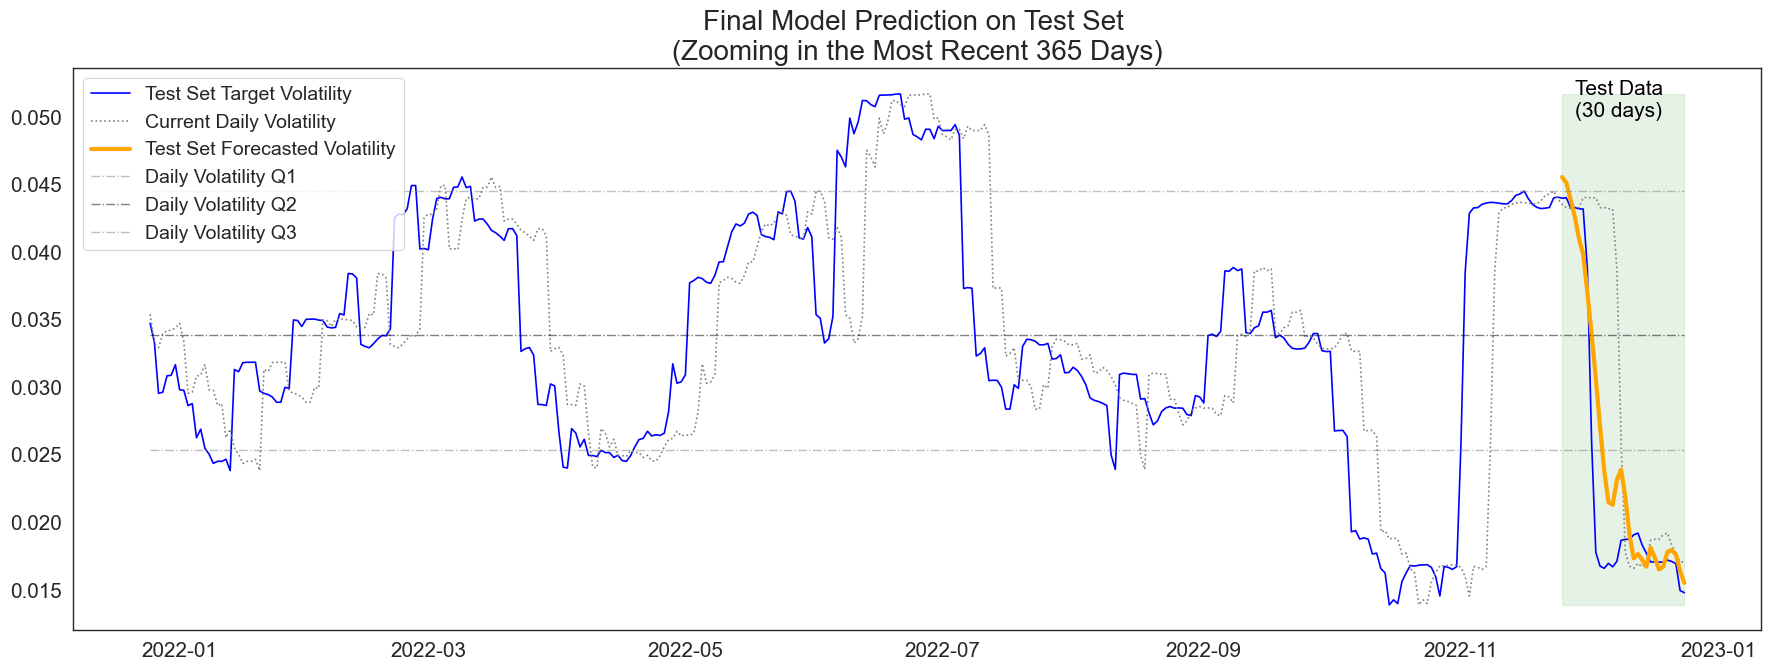

In [201]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig('final_lstm_test_preds.png', dpi=300, bbox_inches='tight')
    plt.show();

In [202]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, 
                                df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-len(mat_X_all):])

93/93 [==============================] - 1s 9ms/step


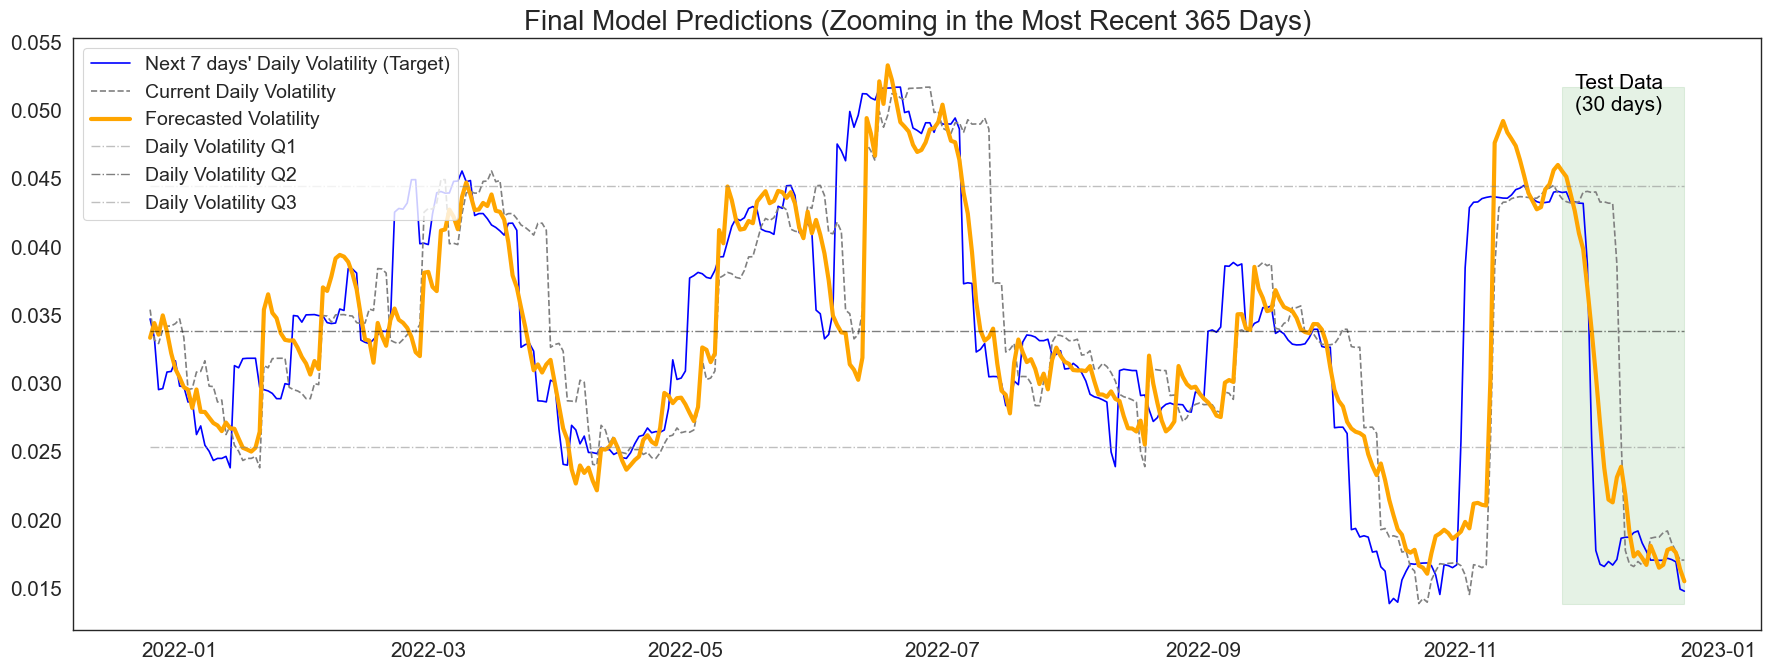

In [203]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig('final_lstm_preds.png', dpi=300, bbox_inches='tight')
    plt.show();

In [204]:
perf_df

Model  \
0                                         TGARCH(1,1,1), Constant Mean, T Dist   
1  Multivariate Bidirect LSTM-TGARCH (128/64/32/16 units), n_past=30, batch=64   
2   Multivariate Bidirect GRU-TGARCH (128/64/32/16 units), n_past=30, batch=64   
3            Multivariate FNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   
4            Multivariate RNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   
5            Multivariate CNN-TGARCH (128/64/32/16 units), n_past=30, batch=64   

   Validation RMSPE  Validation RMSE  
0          0.260340         0.075596  
1          0.217390         0.051033  
2          0.194446         0.055911  
3          0.286206         0.073471  
4          0.272142         0.080651  
5          0.441380         0.118010

In [205]:
perf_df.to_pickle("performance_df.pkl")

In [206]:
RMSPE(y_test, y_test_preds)

0.23244177864302776

# **Conclusion**

A trader does not need to make perfectly accurate forecast to have a positive expectation when participating in the markets, he/she just needs to make a forecast that is both correct (ie. bullish or bearish) and **more correct than the consensus**. 

My final LSTM model has an RMSPE of 0.047 on the Test set (which is the most recent 30 days of which future volatility data is available for comparison). Since RMSPE indicates the average magnitude of the error in relation to the actual values, that translates to a magnitude accuracy of 94.8% on the average 7-day horizon daily volatility forecasting within the period of 07/26/2021 to 08/24/2021.  

In terms of performance on the validation set, LSTM model has an RMSPE of 0.161375, which is roughly 4.02% better than the best performing variant of the EGARCH models - TARCH(1,2) with an RMSPE of 0.201579.

However, since financial time series data are constantly evolving, no model would be able to consistently forecast with high accuracy level forever. The average lifetime of a model is between 6 months to 5 years, and there's a phenomenon in quant trading that is called **alpha decay**, which is the loss in predictive power of an alpha model over time. In addition, researchers have proved that the publication of a new "edge" or anomaly in the markets lessens its returns by up to 58%. 

These models therfore require constant tweaking and tuning based on the most recent information available to make sure the model stays up-to-date and learn to evolve with the markets. 



# **Next Steps**

As briefly mentioned above, I think there's potential application of WaveNet in the forecasting of volatility, and would like to explore that option in the future.

In addition, it's common knowledge that economic events could affect markets' dynamics. Since cryptocurrencies have cerain nuances that are different from other stocks and commodities', incorporating the regular economic calendars' events might not be the most relevant. I am currently still doing more research on collecting significant events that could have driven Bitcoin movements, and would like to incorporate that in another Multivariate LSTM set of models in the future to hopefully improve predictive power even more.